In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
import random
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)  # Prevents line wrapping
pd.set_option('display.width', 1000)  # Set an arbitrary high width

# Loading data

In [4]:
##Load my data
df_clin = pd.read_csv(r'..\data\clinFeatures_UPENN.csv')
df_rad = pd.read_csv(r'..\data\radFeatures_UPENN.csv')

In [5]:
# merge both dataframes with the same SubjectID
data = pd.merge(df_clin, df_rad, on=['SubjectID'])
original_shape = data.shape
print('Original Data Shape: ', original_shape)

Original Data Shape:  (611, 4762)


# First data cleaning

In [6]:
# Replace "Not Available" with np.nan
data.replace("Not Available", np.nan, inplace=True)

data_ML = pd.DataFrame(data) # duplicating data set that will be modified

# Delet Subject ID
data_ML.drop(columns='SubjectID', inplace=True)

# drop rows where label is not available
data_ML.dropna(subset=['Survival_from_surgery_days'], inplace=True)

# Dropping columns with more than 20% missing data
threshold = 20  # Percentage threshold for dropping columns
percent_missing = data_ML.isnull().mean() * 100
columns_to_drop = percent_missing[percent_missing > threshold].index

# Removing 'Survival_from_surgery_days' then dropping columns
data_ML.drop(columns=columns_to_drop, inplace=True)

print('Data shape after first cleanup: ', data_ML.shape)

Data shape after first cleanup:  (452, 3462)


# Data Description

In [7]:
print('Shape original dataset: ', original_shape)
print('Shape after first cleanup', data_ML.shape)

Shape original dataset:  (611, 4762)
Shape after first cleanup (452, 3462)


### Missing values 

In [8]:
missing_values_per_column = data.isna().sum()

# Print the number of missing values per column
print("Number of missing values per column:")
print(missing_values_per_column)

# Count the number of columns with at least one missing value
num_columns_with_missing_values = (missing_values_per_column > 0).sum()

# Print the number of columns with missing values
print("\nNumber of columns with missing values:", num_columns_with_missing_values)

no_miss = (missing_values_per_column == 0).sum()
print('Number of columns with missing values:', no_miss)

Number of missing values per column:
SubjectID                               0
Gender                                  0
Age_at_scan_years                       0
Survival_from_surgery_days            159
IDH1                                    0
                                     ... 
DSC_PH_ED_NGTDM_Coarsness             137
DSC_PH_ED_NGTDM_Complexity            137
DSC_PH_ED_NGTDM_Contrast              137
DSC_PH_ED_NGTDM_Strength              137
DSC_PH_ED_LBP_Radius-1_Bins-16_LBP    137
Length: 4762, dtype: int64

Number of columns with missing values: 4181
Number of columns with missing values: 581


In [9]:
print('Missing values in descending order:')
data.isna().sum().sort_values(ascending=False)

Missing values in descending order:


PsP_TP_score                                                               611
KPS                                                                        536
MGMT                                                                       322
Survival_from_surgery_days                                                 159
DSC_ap-rCBV_ED_Histogram_Bins-16_Bins-16_QuartileCoefficientOfVariation    158
                                                                          ... 
T1GD_ED_Intensity_CoefficientOfVariation                                     0
T1GD_ED_Intensity_Energy                                                     0
T1GD_ED_Intensity_InterQuartileRange                                         0
T1GD_ED_Intensity_Kurtosis                                                   0
SubjectID                                                                    0
Length: 4762, dtype: int64

### Data Types

In [10]:
print(data.dtypes)
print('\n Columns per data type:')
print(data.dtypes.value_counts())

SubjectID                              object
Gender                                 object
Age_at_scan_years                     float64
Survival_from_surgery_days             object
IDH1                                   object
                                       ...   
DSC_PH_ED_NGTDM_Coarsness             float64
DSC_PH_ED_NGTDM_Complexity            float64
DSC_PH_ED_NGTDM_Contrast              float64
DSC_PH_ED_NGTDM_Strength              float64
DSC_PH_ED_LBP_Radius-1_Bins-16_LBP    float64
Length: 4762, dtype: object

 Columns per data type:
float64    4565
int64       190
object        7
Name: count, dtype: int64


In [11]:
# change 'survival_from_surgery_days' to numeric
data['Survival_from_surgery_days'] = pd.to_numeric(data['Survival_from_surgery_days'], errors='coerce')

In [12]:
print(data.dtypes)
print('\n Columns per data type:')
print(data.dtypes.value_counts())

SubjectID                              object
Gender                                 object
Age_at_scan_years                     float64
Survival_from_surgery_days            float64
IDH1                                   object
                                       ...   
DSC_PH_ED_NGTDM_Coarsness             float64
DSC_PH_ED_NGTDM_Complexity            float64
DSC_PH_ED_NGTDM_Contrast              float64
DSC_PH_ED_NGTDM_Strength              float64
DSC_PH_ED_LBP_Radius-1_Bins-16_LBP    float64
Length: 4762, dtype: object

 Columns per data type:
float64    4566
int64       190
object        6
Name: count, dtype: int64


#### Numerical vs. Categorical Features

In [13]:
cat_cols = data.select_dtypes(include=['object']).columns.to_list()

numeric_cols = data.select_dtypes(include=[np.number]).columns.to_list()  # get the names of numeric columns

print('Number of categorical features: ', len(cat_cols))
print('Categorical Features: ', cat_cols)
print('\n Number of numerical features: ', len(numeric_cols))
print('Numerical Features: ', numeric_cols)

Number of categorical features:  6
Categorical Features:  ['SubjectID', 'Gender', 'IDH1', 'MGMT', 'KPS', 'GTR_over90percent']

 Number of numerical features:  4756
Numerical Features:  ['Age_at_scan_years', 'Survival_from_surgery_days', 'Time_since_baseline_preop', 'PsP_TP_score', 'FLAIR_ED_Intensity_CoefficientOfVariation', 'FLAIR_ED_Intensity_Energy', 'FLAIR_ED_Intensity_InterQuartileRange', 'FLAIR_ED_Intensity_Kurtosis', 'FLAIR_ED_Intensity_Maximum', 'FLAIR_ED_Intensity_Mean', 'FLAIR_ED_Intensity_MeanAbsoluteDeviation', 'FLAIR_ED_Intensity_Median', 'FLAIR_ED_Intensity_MedianAbsoluteDeviation', 'FLAIR_ED_Intensity_Minimum', 'FLAIR_ED_Intensity_Mode', 'FLAIR_ED_Intensity_NinetiethPercentile', 'FLAIR_ED_Intensity_QuartileCoefficientOfVariation', 'FLAIR_ED_Intensity_Range', 'FLAIR_ED_Intensity_RootMeanSquare', 'FLAIR_ED_Intensity_Skewness', 'FLAIR_ED_Intensity_StandardDeviation', 'FLAIR_ED_Intensity_Sum', 'FLAIR_ED_Intensity_TenthPercentile', 'FLAIR_ED_Intensity_Variance', 'FLAIR_ED_His

#### Statistics of numerical features

In [14]:
df_stats = pd.DataFrame(columns=['Mean', 'Median', 'Std', 'Min', 'Max'])

def calculate_statistics(column):
    stats = {
        'mean': column.mean(),
        'median': column.median(),
        'std': column.std(),
        'min': column.min(),
        'max': column.max()
    }
    return stats
"""
columns_drop = ['Subject_ID', 'Gender']
columns_drop = [col for col in columns_drop if col in numeric_cols]
stats_var = numeric_cols.drop(columns_drop)

for column in df.columns:
    stats = calculate_statistics(df[column])
    df_stats.loc[column, 'Variable'] = stats['mean']
"""
for column in numeric_cols:
    stats = calculate_statistics(data[column])
    """
    stats_df = df_stats.append({
        'Mean': stats['mean'],
        'Median': stats['median'],
        'Std': stats['std'],
        'Min': stats['min'],
        'Max': stats['max']
        """
    
    df_stats.loc[column, 'Mean'] = stats['mean']
    df_stats.loc[column, 'Median'] = stats['median']
    df_stats.loc[column, 'Std'] = stats['std']
    df_stats.loc[column, 'Min'] = stats['min']
    df_stats.loc[column, 'Max'] = stats['max']

print(df_stats)

                                                    Mean        Median            Std          Min          Max
Age_at_scan_years                              62.977594         63.58      12.424672        18.65         88.5
Survival_from_surgery_days                    422.165929         366.0     355.260164          3.0       2207.0
Time_since_baseline_preop                            0.0           0.0            0.0            0            0
PsP_TP_score                                         NaN           NaN            NaN          NaN          NaN
FLAIR_ED_Intensity_CoefficientOfVariation       0.177191      0.178013       0.038226     0.068381     0.344314
...                                                  ...           ...            ...          ...          ...
DSC_PH_ED_NGTDM_Coarsness                       0.000069      0.000035       0.000101     0.000008     0.000897
DSC_PH_ED_NGTDM_Complexity                    589.350564    574.004535     104.676187   397.386313  1256

### Feature Distribution

#### Gender

In [15]:
gender_counts = data['Gender'].value_counts()

num_female = gender_counts.get('F', 0)
num_male = gender_counts.get('M', 1)

print('Number of females: ', num_female)
print('Number of males: ', num_male)

Number of females:  244
Number of males:  367


#### Survival Rate

C:\Users\pamin\miniconda3\envs\FODS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


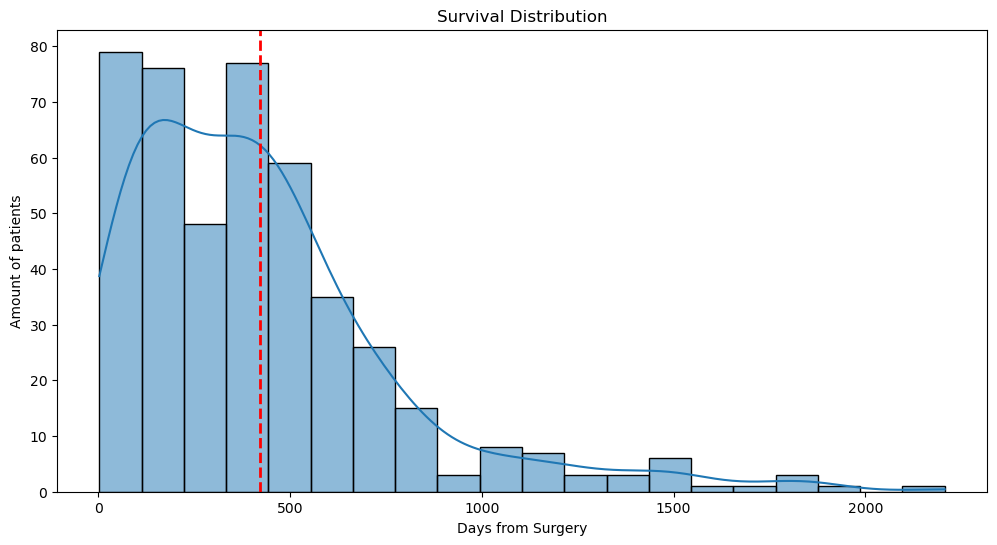

In [16]:
plt.figure(figsize=(12, 6))
num_bins=20
sns.histplot(data=data['Survival_from_surgery_days'], kde="True", bins=num_bins)
plt.axvline(data['Survival_from_surgery_days'].mean(), color = 'r', linestyle = 'dashed', linewidth = 2)
plt.title('Survival Distribution')
plt.xlabel('Days from Surgery')
plt.ylabel('Amount of patients')
plt.show()

In [17]:
mean_survival_days = data['Survival_from_surgery_days'].mean()
print('Mean of Survival (rounded): ', round(mean_survival_days,0), 'days =', round((mean_survival_days/30),0), 'months')

Mean of Survival (rounded):  422.0 days = 14.0 months


#### Age distribution

C:\Users\pamin\miniconda3\envs\FODS\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


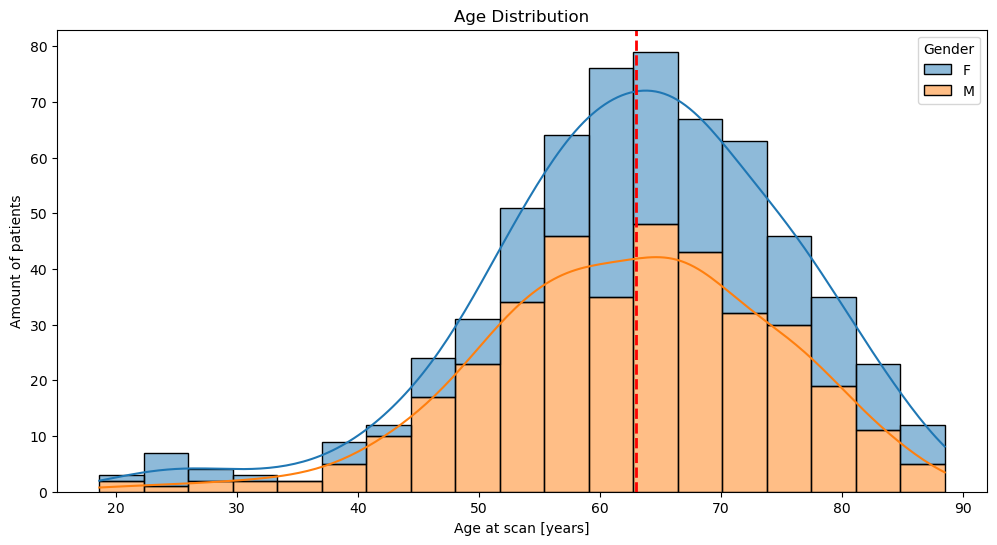

In [18]:
plt.figure(figsize=(12, 6))
sns.histplot(data=data, x='Age_at_scan_years', kde=True, hue=data['Gender'], multiple='stack')
plt.axvline(data['Age_at_scan_years'].mean(), color = 'r', linestyle = 'dashed', linewidth = 2)
plt.title('Age Distribution')
plt.xlabel('Age at scan [years]')
plt.ylabel('Amount of patients')
plt.show()

### Survival depending on Gender and Age

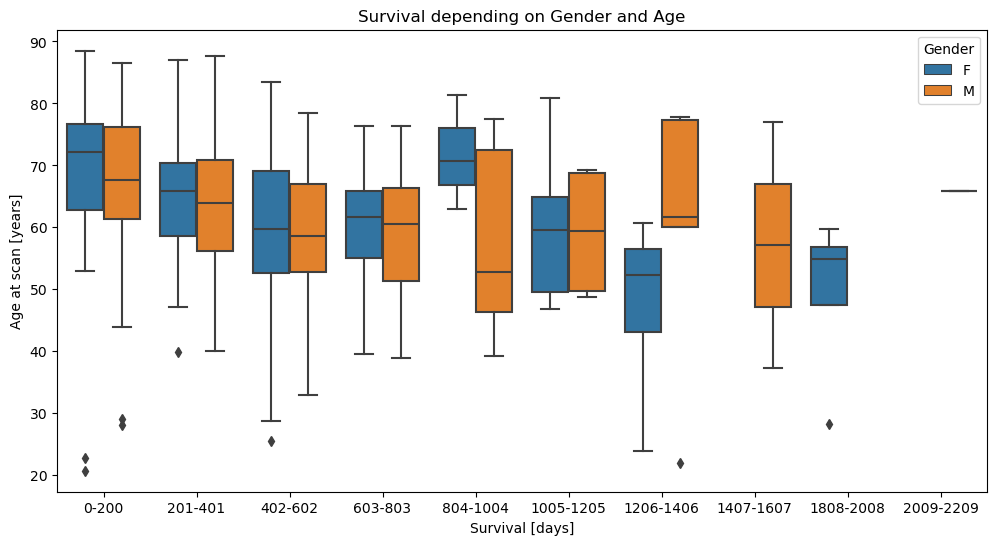

In [19]:
plt.figure(figsize=(12,6))

num_bins = 10
bin_width = 200
bins = pd.cut(data['Survival_from_surgery_days'], bins=num_bins, labels=False, right=False) * bin_width

fig = sns.boxplot(data=data, x=bins, y='Age_at_scan_years', hue=data['Gender'])
plt.xlabel('Survival [days]')
plt.ylabel('Age at scan [years]')
plt.title('Survival depending on Gender and Age')
custom_labels = ['0-200', '201-401', '402-602', '603-803', '804-1004', '1005-1205', '1206-1406', '1407-1607', '1808-2008', '2009-2209']
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels)
plt.show()

# Prepare for training

### Create categories for label

In [20]:
# Convert 'Survival_from_surgery_days' to numeric, forcing errors to NaN
data_ML['Survival_from_surgery_days'] = pd.to_numeric(data_ML['Survival_from_surgery_days'], errors='coerce')

# Create two classes out of the continuous life class
mean_survival_days = data_ML['Survival_from_surgery_days'].mean()
data_ML['Survival_from_surgery_days'] = (data_ML['Survival_from_surgery_days'] >= mean_survival_days).astype(int)

# Print the categories
print('Mean of Survival Days: ', round(mean_survival_days,0), ' = ', round((mean_survival_days/30),1), 'months')
print('Categories: ', 'Days < Mean = 0  |  Days > Mean = 1')

short = data_ML['Survival_from_surgery_days'].value_counts()[0]
long = data_ML['Survival_from_surgery_days'].value_counts()[1]

print('Shorter Survival Rate: ', short, 'Patients')
print('Longer Survival Rate: ', long, 'Patients')

Mean of Survival Days:  422.0  =  14.1 months
Categories:  Days < Mean = 0  |  Days > Mean = 1
Shorter Survival Rate:  265 Patients
Longer Survival Rate:  187 Patients


In [21]:
print(data_ML.dtypes.value_counts())

float64    3268
int64       190
object        3
int32         1
Name: count, dtype: int64


In [22]:
# Fill missing values in categorical variables with the mode
cat_variables = ["Gender", "IDH1", "GTR_over90percent"]
for column in cat_variables:
    mode_value = data_ML[column].mode()[0]
    data_ML[column] = data_ML[column].fillna(mode_value)

# Convert numerical columns to numeric, forcing errors to NaN
numeric_cols = data_ML.select_dtypes(include=[np.number]).columns
data_ML[numeric_cols] = data_ML[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Fill missing values in numerical variables with the median
data_ML[numeric_cols] = data_ML[numeric_cols].fillna(data_ML[numeric_cols].median())

# Encode categorical variables using LabelEncoder
label_encoders = {}
for column in cat_variables:
    le = LabelEncoder()
    data_ML[column] = le.fit_transform(data_ML[column])
    label_encoders[column] = le

original_column_names = data_ML.columns.tolist()

selector = VarianceThreshold(threshold=0.01)
data_ML_filtered = selector.fit_transform(data_ML)

# Reapply column names
selected_columns = selector.get_support(indices=True)
selected_column_names = [original_column_names[i] for i in selected_columns]
data_ML_filtered = pd.DataFrame(data_ML_filtered, columns=selected_column_names)
data_ML = data_ML_filtered

# Identify numerical columns excluding categorical ones
name_columns = selected_column_names.copy()

# Remove the column that was deleted
column_to_delete = 'Survival_from_surgery_days'
if column_to_delete in name_columns:
    name_columns.remove(column_to_delete)

print(data_ML.shape)
print(name_columns)


(452, 2389)
['Gender', 'Age_at_scan_years', 'IDH1', 'GTR_over90percent', 'FLAIR_ED_Intensity_Energy', 'FLAIR_ED_Intensity_InterQuartileRange', 'FLAIR_ED_Intensity_Kurtosis', 'FLAIR_ED_Intensity_Maximum', 'FLAIR_ED_Intensity_Mean', 'FLAIR_ED_Intensity_Median', 'FLAIR_ED_Intensity_MedianAbsoluteDeviation', 'FLAIR_ED_Intensity_Minimum', 'FLAIR_ED_Intensity_Mode', 'FLAIR_ED_Intensity_NinetiethPercentile', 'FLAIR_ED_Intensity_Range', 'FLAIR_ED_Intensity_RootMeanSquare', 'FLAIR_ED_Intensity_Skewness', 'FLAIR_ED_Intensity_StandardDeviation', 'FLAIR_ED_Intensity_Sum', 'FLAIR_ED_Intensity_TenthPercentile', 'FLAIR_ED_Intensity_Variance', 'FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-0_Frequency', 'FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-10_Frequency', 'FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-11_Frequency', 'FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-12_Frequency', 'FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-13_Frequency', 'FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-14_Frequency', 'FLAIR_ED_Histogram_Bins-16_Bins-16

In [23]:
print(data_ML.dtypes)

Gender                                             float64
Age_at_scan_years                                  float64
Survival_from_surgery_days                         float64
IDH1                                               float64
GTR_over90percent                                  float64
                                                    ...   
T1GD_ET_GLSZM_Bins-16_Radius-1_ZoneSizeVariance    float64
T1GD_ET_NGTDM_Busyness                             float64
T1GD_ET_NGTDM_Complexity                           float64
T1GD_ET_NGTDM_Contrast                             float64
T1GD_ET_LBP_Radius-1_Bins-16_LBP                   float64
Length: 2389, dtype: object


#### Split test and training set and Standardize features

In [24]:
X = data_ML.drop('Survival_from_surgery_days', axis=1)
y = data_ML['Survival_from_surgery_days']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=1
)

# Define the columns to exclude
cat_variables = ["Gender", "IDH1", "GTR_over90percent", "Survival_from_surgery_days"]

# Create a list of columns excluding the specified categorical variables
columns_to_include = [col for col in data_ML.columns if col not in cat_variables]

# Standardizing features
scaler = StandardScaler()
X_train[columns_to_include] = scaler.fit_transform(X_train[columns_to_include])
X_test[columns_to_include] = scaler.transform(X_test[columns_to_include])

print('Size Trainingsset:', X_train.shape[0], ', Size Testset:', X_test.shape[0])


Size Trainingsset: 361 , Size Testset: 91


#### Create Balanced Subset

In [25]:
# Reset index of y_train
y_train_reset_index = y_train.reset_index(drop=True)

# Create balanced subset for training
pats_pos_train_idx = np.random.choice(np.where(y_train_reset_index == 1)[0], 100)
pats_neg_train_idx = np.random.choice(np.where(y_train_reset_index == 0)[0], 100)
X_train_sub = X_train.iloc[pats_pos_train_idx.tolist() + pats_neg_train_idx.tolist()]
y_train_sub = y_train_reset_index.iloc[pats_pos_train_idx.tolist() + pats_neg_train_idx.tolist()]

# Reset index of y_test
y_test_reset_index = y_test.reset_index(drop=True)

# Create balanced subset for testing
pats_pos_test_idx = np.random.choice(np.where(y_test_reset_index == 1)[0], 100)
pats_neg_test_idx = np.random.choice(np.where(y_test_reset_index == 0)[0], 100)
X_test_sub = X_test.iloc[pats_pos_test_idx.tolist() + pats_neg_test_idx.tolist()]
y_test_sub = y_test_reset_index.iloc[pats_pos_test_idx.tolist() + pats_neg_test_idx.tolist()]

#### Function to evaluate Performance

In [26]:
def eval_Performance(y_eval, X_eval, clf, clf_name='My Classifier'):

    y_pred = clf.predict(X_eval)
    y_pred_proba = clf.predict_proba(X_eval)[:, 1]
    tn, fp, fn, tp = confusion_matrix(y_eval, y_pred).ravel()

    # Evaluation
    accuracy = accuracy_score(y_eval, y_pred)
    precision = precision_score(y_eval, y_pred, average='macro')
    recall = recall_score(y_eval, y_pred, average='macro')
    specificity = tn / (tn + fp)
    f1 = f1_score(y_eval, y_pred, average='macro')
    fp_rates, tp_rates, _ = roc_curve(y_eval, y_pred_proba)

    # Calculate the area under the roc curve using a sklearn function
    roc_auc = auc(fp_rates, tp_rates)

    return tp, fp, tn, fn, accuracy, precision, specificity, recall, f1, roc_auc

In [27]:
def plot_roc_curve(y_true, y_pred_proba, title='ROC Curve'):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

# Machine learning models

## Logistical regression model

### Basic model

In [28]:
# Define the extended hyperparameters grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],                                  # Regularization parameter
    'solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'],  # Optimization algorithm
    'tol': [1e-4, 1e-3, 1e-2],                                     # Tolerance for stopping criteria
    'fit_intercept': [True, False],                                # Whether to calculate the intercept
    'intercept_scaling': [1, 2, 3]                                 # Scaling factor for the intercept
}

clf_LR = LogisticRegression(random_state=1, class_weight='balanced', max_iter=10000)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=clf_LR, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'C': 100, 'fit_intercept': True, 'intercept_scaling': 3, 'solver': 'liblinear', 'tol': 0.01}
Best score: 0.6067351598173516


In [29]:
clf_LR = LogisticRegression(random_state=1, class_weight='balanced', max_iter=10000, C = 100, fit_intercept = True, intercept_scaling = 3, 
                            solver = 'liblinear', tol = 0.01)
clf_LR.fit(X_train, y_train)

df_performance_LR = pd.DataFrame(columns = ['tp','fp','tn','fn','accuracy', 'precision', 'recall', 'specificity', 'f1', 'roc_auc'] )
df_performance_LR.loc['LR (test)',:] = eval_Performance(y_test, X_test, clf_LR, clf_name = 'LR')
df_performance_LR.loc['LR (train)',:] = eval_Performance(y_train, X_train, clf_LR, clf_name = 'LR (train)')
print(df_performance_LR)

             tp  fp   tn  fn  accuracy precision    recall specificity        f1   roc_auc
LR (test)    24  17   31  19  0.604396  0.602683  0.645833    0.601986  0.602041  0.626453
LR (train)  144   0  217   0       1.0       1.0       1.0         1.0       1.0       1.0


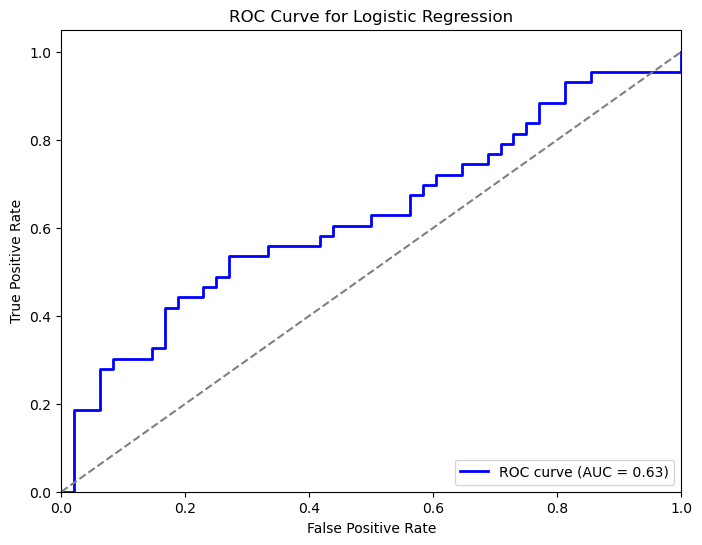

In [30]:
y_pred_proba = clf_LR.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_pred_proba, title='ROC Curve for Logistic Regression')

### With only the best 600 features

In [31]:
coefficients = clf_LR.coef_[0]

# Get the feature names from your data (assuming clf_LR and X_train are already defined)
feature_names = X_train.columns.tolist()

coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Absolute values for easier comparison
coefficients_df['Abs_Coefficient'] = np.abs(coefficients_df['Coefficient'])


In [32]:
print(coefficients_df)

                                              Feature  Coefficient  Abs_Coefficient
0                                              Gender    -0.062280         0.062280
1                                   Age_at_scan_years    -1.148012         1.148012
2                                                IDH1    -0.144578         0.144578
3                                   GTR_over90percent     0.648324         0.648324
4                           FLAIR_ED_Intensity_Energy    -0.186648         0.186648
...                                               ...          ...              ...
2383  T1GD_ET_GLSZM_Bins-16_Radius-1_ZoneSizeVariance     0.394327         0.394327
2384                           T1GD_ET_NGTDM_Busyness    -0.054371         0.054371
2385                         T1GD_ET_NGTDM_Complexity    -0.249030         0.249030
2386                           T1GD_ET_NGTDM_Contrast     0.000546         0.000546
2387                 T1GD_ET_LBP_Radius-1_Bins-16_LBP    -0.035902         0

In [33]:
# Select Best Features

# Train- and Testset
num_features_to_select = 600  # Number of top features to select
selected_features = coefficients_df.nlargest(num_features_to_select, 'Abs_Coefficient')['Feature']
selected_indices = selected_features.tolist()  # Convert to list if it's a Pandas Index object

X_train_selected = X_train[selected_indices]
X_test_selected = X_test[selected_indices]

clf_LR_selected = LogisticRegression(random_state=1, class_weight='balanced', max_iter=1000)
clf_LR_selected.fit(X_train_selected, y_train)

print(selected_indices)

['Age_at_scan_years', 'T1_ED_Histogram_Bins-16_Bins-16_MedianAbsoluteDeviation', 'FLAIR_ET_Histogram_Bins-16_Bins-16_MedianAbsoluteDeviation', 'DTI_RD_ET_Histogram_Bins-16_Bins-16_Bin-1_Frequency', 'T1_NC_GLRLM_Bins-16_Radius-1_LongRunEmphasis', 'FLAIR_ET_GLSZM_Bins-16_Radius-1_GreyLevelVariance', 'FLAIR_NC_GLRLM_Bins-16_Radius-1_LongRunEmphasis', 'T2_ET_GLSZM_Bins-16_Radius-1_ZoneSizeEntropy', 'DTI_AD_ED_Histogram_Bins-16_Bins-16_Bin-2_Frequency', 'GTR_over90percent', 'DTI_FA_ET_GLSZM_Bins-16_Radius-1_GreyLevelVariance', 'FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-9_Frequency', 'T2_NC_Histogram_Bins-16_Bins-16_Mode', 'FLAIR_ET_GLSZM_Bins-16_Radius-1_ZoneSizeMean', 'T2_ED_GLSZM_Bins-16_Radius-1_ZoneSizeNonUniformity', 'T2_ET_GLSZM_Bins-16_Radius-1_GreyLevelVariance', 'T2_ED_Histogram_Bins-16_Bins-16_Bin-5_Frequency', 'DTI_AD_ED_Histogram_Bins-16_Bins-16_Bin-3_Frequency', 'T1GD_ED_NGTDM_Complexity', 'DTI_RD_NC_Histogram_Bins-16_Bins-16_Bin-1_Frequency', 'T2_ED_GLSZM_Bins-16_Radius-1_GreyLev

In [34]:
# Top 10 features
top_10_features = coefficients_df.nlargest(10, 'Abs_Coefficient')
selected_features = top_10_features['Feature']
selected_indices = selected_features.tolist() 
print('The best 10 features: ',selected_indices)

The best 10 features:  ['Age_at_scan_years', 'T1_ED_Histogram_Bins-16_Bins-16_MedianAbsoluteDeviation', 'FLAIR_ET_Histogram_Bins-16_Bins-16_MedianAbsoluteDeviation', 'DTI_RD_ET_Histogram_Bins-16_Bins-16_Bin-1_Frequency', 'T1_NC_GLRLM_Bins-16_Radius-1_LongRunEmphasis', 'FLAIR_ET_GLSZM_Bins-16_Radius-1_GreyLevelVariance', 'FLAIR_NC_GLRLM_Bins-16_Radius-1_LongRunEmphasis', 'T2_ET_GLSZM_Bins-16_Radius-1_ZoneSizeEntropy', 'DTI_AD_ED_Histogram_Bins-16_Bins-16_Bin-2_Frequency', 'GTR_over90percent']


In [35]:
df_performance_LR.loc['LR selected (test)',:] = eval_Performance(y_test, X_test_selected, clf_LR_selected, clf_name = 'LR selected')
df_performance_LR.loc['LR selected (train)',:] = eval_Performance(y_train, X_train_selected, clf_LR_selected, clf_name = 'LR selected (train)')
print(df_performance_LR)

                      tp  fp   tn  fn  accuracy precision    recall specificity        f1   roc_auc
LR (test)             24  17   31  19  0.604396  0.602683  0.645833    0.601986  0.602041  0.626453
LR (train)           144   0  217   0       1.0       1.0       1.0         1.0       1.0       1.0
LR selected (test)    22  15   33  21  0.604396  0.602853    0.6875    0.599564  0.598529  0.647771
LR selected (train)  144   0  217   0       1.0       1.0       1.0         1.0       1.0       1.0


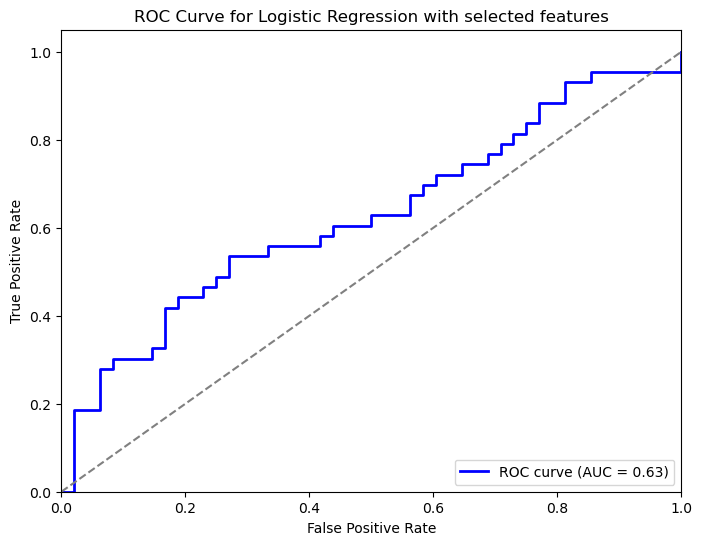

In [36]:
y_pred_proba_selected = clf_LR_selected.predict_proba(X_test_selected)[:, 1]
plot_roc_curve(y_test, y_pred_proba, title='ROC Curve for Logistic Regression with selected features')

### L1 (Lasso)

In [37]:
# Define the hyperparameters grid for L1 regularization
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # Regularization parameter
    'solver': ['liblinear'],                    # Optimization algorithm for L1 penalty
    'penalty': ['l1'],                          # Regularization type (L1 penalty)
    'tol': [1e-4, 1e-3, 1e-2],                  # Tolerance for stopping criteria
    'fit_intercept': [True, False],             # Whether to calculate the intercept
    'intercept_scaling': [1, 2, 3]              # Scaling factor for the intercept
}

# Create the logistic regression model
clf_l1 = LogisticRegression()

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=clf_l1, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'C': 0.1, 'fit_intercept': False, 'intercept_scaling': 3, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.01}
Best score: 0.6757990867579908


In [38]:
clf_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=1, fit_intercept = False, intercept_scaling = 3, tol = 0.01)
clf_l1.fit(X_train, y_train)

# Get the coefficients of the model
coefficients = clf_l1.coef_

# Get the indices of non-zero coefficients
non_zero_indices = np.nonzero(coefficients)

# Get the feature names
feature_names = X_train.columns

# Print the number of features selected by L1 regularization
num_features_selected = len(non_zero_indices[1])
print("Number of features selected by L1 regularization:", num_features_selected)

# Print the names of features selected by L1 regularization
selected_features = [feature_names[i] for i in non_zero_indices[1]]
print("Features selected by L1 regularization:", selected_features)

# Append the performance as new rows to df_performance
df_performance_LR.loc['LR L1 (test)',:] = eval_Performance(y_test, X_test, clf_l1, clf_name = 'LR L1')
df_performance_LR.loc['LR L1 (train)',:] = eval_Performance(y_train, X_train, clf_l1, clf_name = 'LR L1 (train)')

Number of features selected by L1 regularization: 85
Features selected by L1 regularization: ['Age_at_scan_years', 'IDH1', 'FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-12_Frequency', 'FLAIR_ED_GLSZM_Bins-16_Radius-1_ZoneSizeEntropy', 'T1_ED_Histogram_Bins-16_Bins-16_MedianAbsoluteDeviation', 'T1_ED_Morphologic_PerimeterOnBorder', 'T1_ED_GLCM_Bins-16_Radius-1_Correlation', 'T1_ED_GLCM_Bins-16_Radius-1_Entropy', 'T1_ED_GLRLM_Bins-16_Radius-1_LongRunEmphasis', 'DTI_TR_ED_Intensity_Maximum', 'DTI_TR_ED_Intensity_Range', 'DTI_TR_ED_Histogram_Bins-16_Bins-16_Kurtosis', 'DTI_TR_ED_GLCM_Bins-16_Radius-1_ClusterShade', 'DTI_FA_NC_Histogram_Bins-16_Bins-16_Bin-13_Frequency', 'DTI_FA_NC_GLSZM_Bins-16_Radius-1_GreyLevelVariance', 'DTI_TR_ET_Morphologic_Eccentricity', 'DTI_TR_ET_GLCM_Bins-16_Radius-1_AutoCorrelation', 'T1_ET_Intensity_InterQuartileRange', 'T1_ET_Intensity_Minimum', 'T1_ET_Intensity_Range', 'T1_ET_Histogram_Bins-16_Bins-16_Bin-0_Frequency', 'T1_ET_Morphologic_Flatness', 'T1_ET_GLSZM_Bins

In [39]:
print(df_performance_LR)

                      tp  fp   tn  fn  accuracy precision    recall specificity        f1   roc_auc
LR (test)             24  17   31  19  0.604396  0.602683  0.645833    0.601986  0.602041  0.626453
LR (train)           144   0  217   0       1.0       1.0       1.0         1.0       1.0       1.0
LR selected (test)    22  15   33  21  0.604396  0.602853    0.6875    0.599564  0.598529  0.647771
LR selected (train)  144   0  217   0       1.0       1.0       1.0         1.0       1.0       1.0
LR L1 (test)          20  10   38  23  0.637363  0.644809  0.791667    0.628391  0.622596  0.709302
LR L1 (train)         90  17  200  54  0.803324  0.814262  0.921659    0.773329  0.783194   0.88252


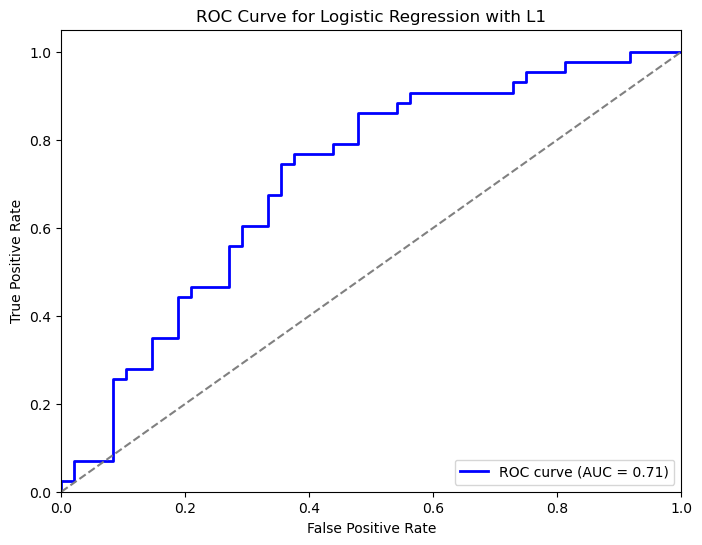

In [40]:
y_pred_proba_l1 = clf_l1.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_pred_proba_l1, title='ROC Curve for Logistic Regression with L1')

### L2 (Ridge)

In [41]:
# Define the hyperparameters grid for L2 regularization
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],        # Regularization parameter
    'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],  # Optimization algorithm for L2 penalty
    'penalty': ['l2'],                                # Regularization type (L2 penalty)
    'tol': [1e-4, 1e-3, 1e-2],                        # Tolerance for stopping criteria
    'fit_intercept': [True, False],                   # Whether to calculate the intercept
    'intercept_scaling': [1, 2, 3]                    # Scaling factor for the intercept
}

# Create the logistic regression model
clf_l2 = LogisticRegression(max_iter=10000)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=clf_l2, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters:", grid_search.best_params_)

# Print the best score found
print("Best score:", grid_search.best_score_)

Best parameters: {'C': 0.001, 'fit_intercept': True, 'intercept_scaling': 3, 'penalty': 'l2', 'solver': 'sag', 'tol': 0.01}
Best score: 0.6342085235920852


In [42]:
clf_l2 = LogisticRegression(penalty='l2', solver='sag', C=0.001, tol = 0.01 , fit_intercept = True, intercept_scaling = 3 ,random_state=1)
clf_l2.fit(X_train, y_train)

# Append the performance as new rows to df_performance_LR
df_performance_LR.loc['LR L2 (test)',:] = eval_Performance(y_test, X_test, clf_l2, clf_name = 'LR L2')
df_performance_LR.loc['LR L2 (train)',:] = eval_Performance(y_train, X_train, clf_l2, clf_name = 'LR L2 (train)')

print(df_performance_LR)

                      tp  fp   tn  fn  accuracy precision    recall specificity        f1   roc_auc
LR (test)             24  17   31  19  0.604396  0.602683  0.645833    0.601986  0.602041  0.626453
LR (train)           144   0  217   0       1.0       1.0       1.0         1.0       1.0       1.0
LR selected (test)    22  15   33  21  0.604396  0.602853    0.6875    0.599564  0.598529  0.647771
LR selected (train)  144   0  217   0       1.0       1.0       1.0         1.0       1.0       1.0
LR L1 (test)          20  10   38  23  0.637363  0.644809  0.791667    0.628391  0.622596  0.709302
LR L1 (train)         90  17  200  54  0.803324  0.814262  0.921659    0.773329  0.783194   0.88252
LR L2 (test)          14  13   35  29  0.538462  0.532697  0.729167    0.527374    0.5125  0.606589
LR L2 (train)         85  19  198  59  0.783934  0.793868  0.912442     0.75136  0.760463  0.874296


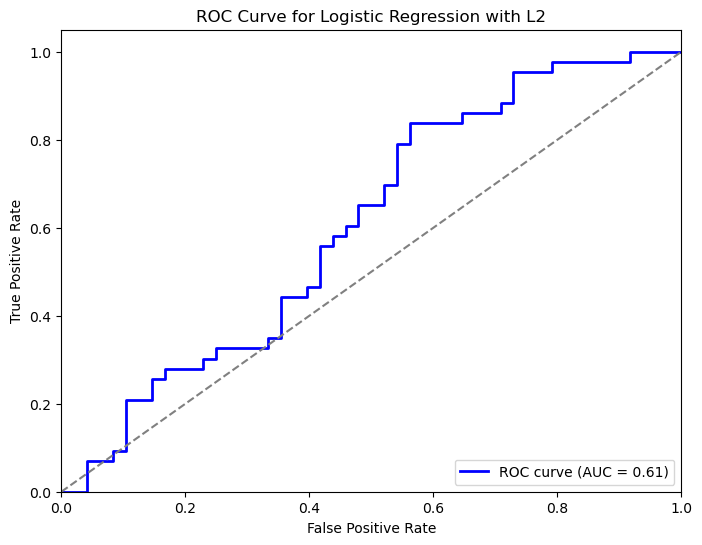

In [43]:
y_pred_proba_l2 = clf_l2.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_pred_proba_l2, title='ROC Curve for Logistic Regression with L2')

### Balanced Model

In [45]:
# Define the hyperparameters grid 
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],                     # Regularization parameter
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],  # Optimization algorithm
    'tol': [1e-4, 1e-3, 1e-2],                                     # Tolerance for stopping criteria
    'fit_intercept': [True, False],                                # Whether to calculate the intercept
    'intercept_scaling': [1, 2, 3],                                # Scaling factor for the intercept
    'class_weight': [None, 'balanced']                             # Class weights
}

# Create the logistic regression model
clf_LR_sub = LogisticRegression(max_iter = 10000)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=clf_LR_sub, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train_sub, y_train_sub)

# Print the best parameters found
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'C': 0.1, 'class_weight': None, 'fit_intercept': True, 'intercept_scaling': 1, 'solver': 'sag', 'tol': 0.0001}
Best score: 0.85


In [46]:
# Fit logistic regression model
clf_LR_sub = LogisticRegression(C = 0.1, class_weight = None, fit_intercept = True, intercept_scaling = 1, max_iter = 10000, 
                                solver = 'sag', tol = 0.0001)
clf_LR_sub.fit(X_train_sub, y_train_sub)

# Evaluate performance
df_performance_LR.loc['LR balanced subset (test)', :] = eval_Performance(y_test_sub, X_test_sub, clf_LR_sub, clf_name='LR balanced subset (test)')
df_performance_LR.loc['LR balanced subset (train)', :] = eval_Performance(y_train_sub, X_train_sub, clf_LR_sub, clf_name='LR balanced subset (train)')

# Display performance
print(df_performance_LR)

                             tp  fp   tn  fn  accuracy precision    recall specificity        f1   roc_auc
LR (test)                    24  17   31  19  0.604396  0.602683  0.645833    0.601986  0.602041  0.626453
LR (train)                  144   0  217   0       1.0       1.0       1.0         1.0       1.0       1.0
LR selected (test)           22  15   33  21  0.604396  0.602853    0.6875    0.599564  0.598529  0.647771
LR selected (train)         144   0  217   0       1.0       1.0       1.0         1.0       1.0       1.0
LR L1 (test)                 20  10   38  23  0.637363  0.644809  0.791667    0.628391  0.622596  0.709302
LR L1 (train)                90  17  200  54  0.803324  0.814262  0.921659    0.773329  0.783194   0.88252
LR L2 (test)                 14  13   35  29  0.538462  0.532697  0.729167    0.527374    0.5125  0.606589
LR L2 (train)                85  19  198  59  0.783934  0.793868  0.912442     0.75136  0.760463  0.874296
LR balanced subset (test)    55  45  

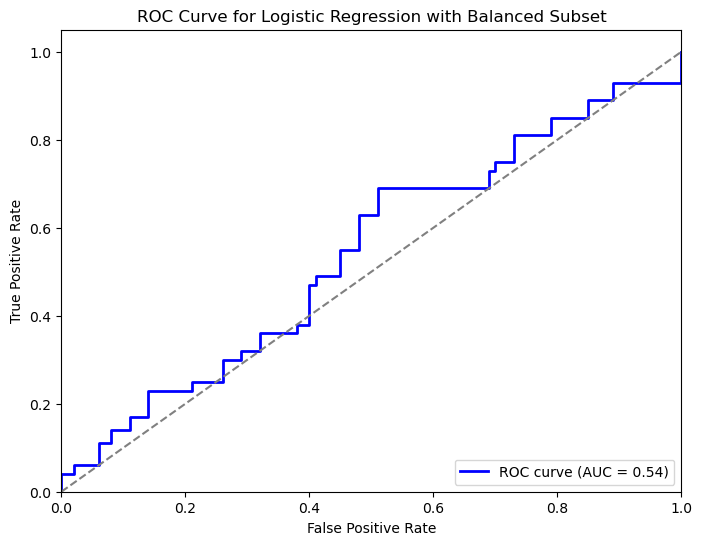

In [47]:
y_pred_proba_sub = clf_LR_sub.predict_proba(X_test_sub)[:, 1]
plot_roc_curve(y_test_sub, y_pred_proba_sub, title='ROC Curve for Logistic Regression with Balanced Subset')

### Results Logistic Regression

In [48]:
print(df_performance_LR)

                             tp  fp   tn  fn  accuracy precision    recall specificity        f1   roc_auc
LR (test)                    24  17   31  19  0.604396  0.602683  0.645833    0.601986  0.602041  0.626453
LR (train)                  144   0  217   0       1.0       1.0       1.0         1.0       1.0       1.0
LR selected (test)           22  15   33  21  0.604396  0.602853    0.6875    0.599564  0.598529  0.647771
LR selected (train)         144   0  217   0       1.0       1.0       1.0         1.0       1.0       1.0
LR L1 (test)                 20  10   38  23  0.637363  0.644809  0.791667    0.628391  0.622596  0.709302
LR L1 (train)                90  17  200  54  0.803324  0.814262  0.921659    0.773329  0.783194   0.88252
LR L2 (test)                 14  13   35  29  0.538462  0.532697  0.729167    0.527374    0.5125  0.606589
LR L2 (train)                85  19  198  59  0.783934  0.793868  0.912442     0.75136  0.760463  0.874296
LR balanced subset (test)    55  45  

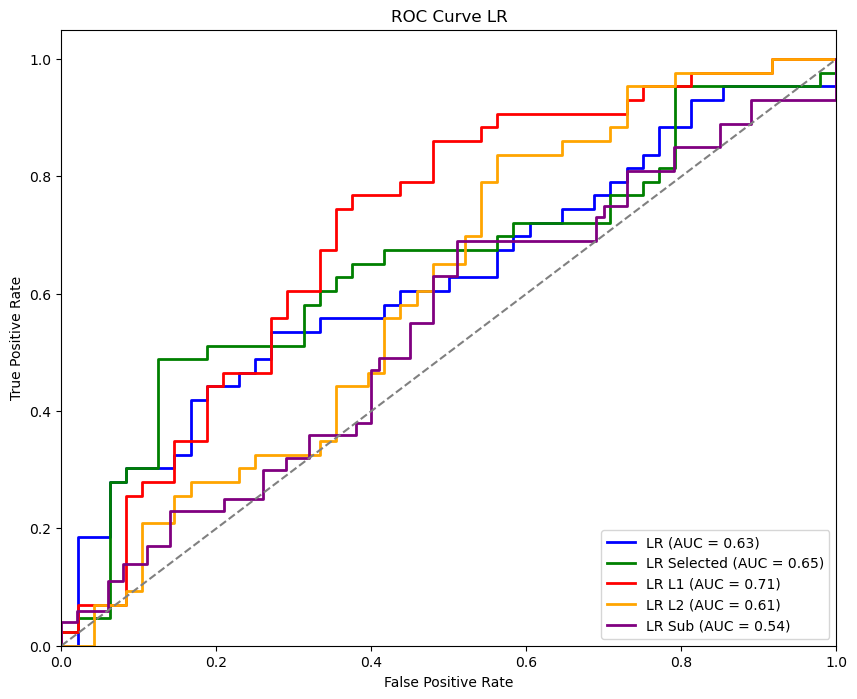

In [49]:
y_pred_proba_LR = clf_LR.predict_proba(X_test)[:, 1]
y_pred_proba_selected = clf_LR_selected.predict_proba(X_test_selected)[:, 1]
y_pred_proba_l1 = clf_l1.predict_proba(X_test)[:, 1]
y_pred_proba_l2 = clf_l2.predict_proba(X_test)[:, 1]
y_pred_proba_sub = clf_LR_sub.predict_proba(X_test_sub)[:, 1]

plt.figure(figsize=(10, 8))

# Plot ROC curve for each model
fpr_LR, tpr_LR, _ = roc_curve(y_test, y_pred_proba_LR)
fpr_selected, tpr_selected, _ = roc_curve(y_test, y_pred_proba_selected)
fpr_l1, tpr_l1, _ = roc_curve(y_test, y_pred_proba_l1)
fpr_l2, tpr_l2, _ = roc_curve(y_test, y_pred_proba_l2)
fpr_sub, tpr_sub, _ = roc_curve(y_test_sub, y_pred_proba_sub)

plt.plot(fpr_LR, tpr_LR, color='blue', lw=2, label='LR (AUC = %0.2f)' % auc(fpr_LR, tpr_LR))
plt.plot(fpr_selected, tpr_selected, color='green', lw=2, label='LR Selected (AUC = %0.2f)' % auc(fpr_selected, tpr_selected))
plt.plot(fpr_l1, tpr_l1, color='red', lw=2, label='LR L1 (AUC = %0.2f)' % auc(fpr_l1, tpr_l1))
plt.plot(fpr_l2, tpr_l2, color='orange', lw=2, label='LR L2 (AUC = %0.2f)' % auc(fpr_l2, tpr_l2))
plt.plot(fpr_sub, tpr_sub, color='purple', lw=2, label='LR Sub (AUC = %0.2f)' % auc(fpr_sub, tpr_sub))

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve LR')
plt.legend(loc='lower right')
plt.show()

## SVM Model

### Basic Model

In [50]:
# Grid search for SVM hyperparameter:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],      # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'], # Kernel function
    'gamma': ['scale', 'auto'],                     # Kernel coefficient
    'degree': [2, 3, 4, 5],                         # Degree of polynomial kernel (if applicable)
    'coef0': [0.0, 0.1, 0.5, 1.0]                  # Coefficient for polynomial and sigmoid kernels (if applicable)
}

# Create an SVM classifier
clf_SVM_grid = svm.SVC()

scoring = {'accuracy': 'accuracy', 'precision': 'precision', 'f1': 'f1'}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=clf_SVM_grid, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'C': 100, 'coef0': 0.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'sigmoid'}
Best Score: 0.6427321156773211


In [51]:
# fitting the basic model with the best parameters
clf_SVM = svm.SVC(probability=True, kernel = 'sigmoid', gamma = 'scale', C = 100, coef0 = 0.0, degree = 2)
clf_SVM.fit(X_train, y_train)

# See model performance
df_performance_SVM = pd.DataFrame(columns = ['tp','fp','tn','fn','accuracy', 'precision', 'recall', 'specificity', 'f1', 'roc_auc'] )
df_performance_SVM.loc['SVM (test)',:] = eval_Performance(y_test, X_test, clf_SVM, clf_name = 'SVM (test)')
df_performance_SVM.loc['SVM (train)',:] = eval_Performance(y_train, X_train, clf_SVM, clf_name = 'SVM (train)')

print(df_performance_SVM)

             tp  fp   tn  fn accuracy precision    recall specificity        f1   roc_auc
SVM (test)   18  15   33  25  0.56044   0.55721    0.6875    0.553052  0.548163   0.51187
SVM (train)  81  55  162  63  0.67313  0.657794  0.746544    0.654522  0.655802  0.616615


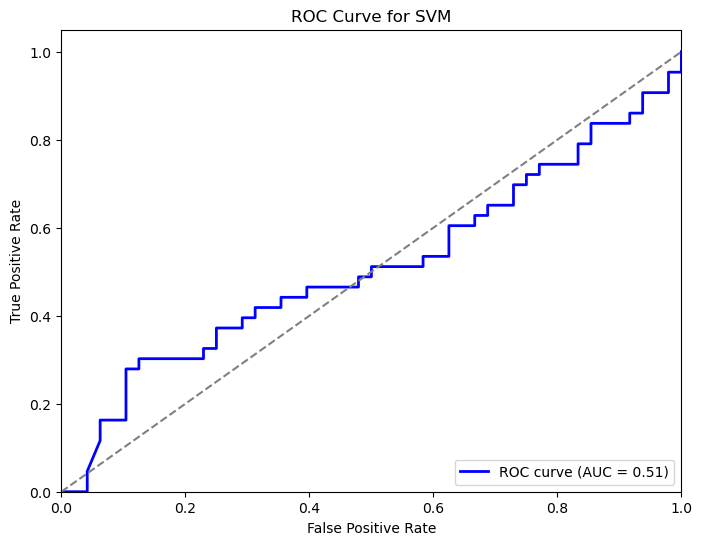

In [52]:
y_pred_proba_svm = clf_SVM.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_pred_proba_svm, title='ROC Curve for SVM')

### UVFS Model

In [53]:
# Using the UVFS selector
UVFS_Selector = SelectKBest(f_classif, k=600) # Select top 600 features
X_train_UVFS = UVFS_Selector.fit_transform(X_train, y_train)
X_test_UVFS = UVFS_Selector.transform(X_test)

In [62]:
# Grid search for SVM with UVFS hyperparameter:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4, 5],
    'gamma': ['scale', 'auto'],
    'coef0': [0.0, 0.1, 0.5, 1.0]
}

# Create SVM classifier
svm_clf_UVFS = svm.SVC()

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=svm_clf_UVFS, param_grid=param_grid, cv=5, n_jobs=-1)

# Perform grid search on data (X_train_UVFS)
grid_search.fit(X_train_UVFS, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'C': 10, 'coef0': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
Best Score: 0.686986301369863


In [54]:
# Train SVM model with selscted features from UVFS and hyperparameter
clf_SVM_UVFS = svm.SVC(C=10, probability=True, kernel = 'poly', gamma='scale', coef0 = 0.1, degree = 2)
clf_SVM_UVFS.fit(X_train_UVFS, y_train)

# Evaluate the performance
df_performance_SVM.loc['SVM UVFS (test)',:] = eval_Performance(y_test, X_test_UVFS, clf_SVM_UVFS, clf_name = 'SVM UVFS')
df_performance_SVM.loc['SVM UVFS (train)',:] = eval_Performance(y_train, X_train_UVFS, clf_SVM_UVFS, clf_name = 'SVM UVFS (train)')

print(df_performance_SVM)

                   tp  fp   tn  fn  accuracy precision    recall specificity        f1   roc_auc
SVM (test)         18  15   33  25   0.56044   0.55721    0.6875    0.553052  0.548163   0.51187
SVM (train)        81  55  162  63   0.67313  0.657794  0.746544    0.654522  0.655802  0.616615
SVM UVFS (test)    10  16   32  33  0.461538  0.438462  0.666667    0.449612  0.428113  0.539486
SVM UVFS (train)  140   0  217   4   0.98892   0.99095       1.0    0.986111  0.988392  0.999968


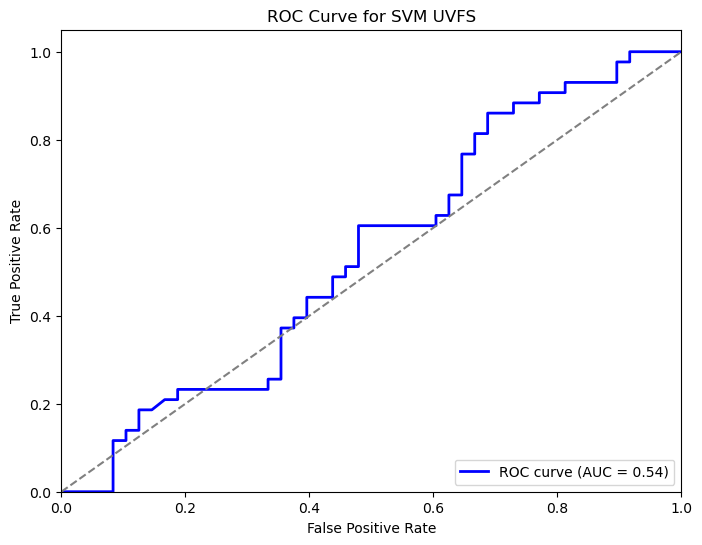

In [55]:
y_pred_proba_svm_uvfs = clf_SVM_UVFS.predict_proba(X_test_UVFS)[:, 1]
plot_roc_curve(y_test, y_pred_proba_svm_uvfs, title='ROC Curve for SVM UVFS')

### Lasso (L1)

In [66]:
# Grid search for SVM with L1 hyperparameter:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],      # Regularization parameter
    'dual': [False, True],                          # Dual parameter
    'loss': ['squared_hinge', 'hinge'],             # Loss function
    'class_weight': [None, 'balanced'],             # Class weights
    'fit_intercept': [True, False]                  # Whether to calculate the intercept
}


# Initialize the L1 SVM classifier
clf_SVM_L1_grid = LinearSVC(penalty='l1', max_iter=10000)

# Perform grid search
grid_search = GridSearchCV(estimator=clf_SVM_L1_grid, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'C': 0.01, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'loss': 'squared_hinge'}
Best Score: 0.6926179604261795


C:\Users\pamin\miniconda3\envs\FODS\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
420 fits failed out of a total of 560.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\pamin\miniconda3\envs\FODS\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\pamin\miniconda3\envs\FODS\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\pamin\miniconda3\envs\FODS\Lib\site-packages\sklearn\svm\_classes.

In [56]:
# Train SVM model with selscted features from L1 and hyperparameter
clf_SVM_L1 = LinearSVC(penalty='l1', dual=False, C = 0.01, loss = 'squared_hinge' , class_weight = None, fit_intercept = True)
clf_SVM_L1.fit(X_train, y_train)

# Get the non-zero coefficients
non_zero_indices = clf_SVM_L1.coef_.nonzero()[1]

# Get the corresponding feature names
selected_features = X_train.columns[non_zero_indices]

num_selected_features = np.count_nonzero(clf_SVM_L1.coef_)
print("Number of features selected by L1 regularization:", num_selected_features)

# Print the selected features
print("Selected features by L1 regularization:")
print(selected_features)

calibrated_clf_l1 = CalibratedClassifierCV(clf_SVM_L1, method='sigmoid')
calibrated_clf_l1.fit(X_train, y_train)

# Evaluate performance on the test set
y_pred_proba_test = calibrated_clf_l1.predict_proba(X_test)[:, 1]
y_pred_test = calibrated_clf_l1.predict(X_test)
tp_test, fp_test, tn_test, fn_test, accuracy_test, precision_test, recall_test, specificity_test, f1_test, roc_auc_test = eval_Performance(y_test, X_test, calibrated_clf_l1, clf_name='SVM L1 (test)')

# Evaluate performance on the training set
y_pred_proba_train = calibrated_clf_l1.predict_proba(X_train)[:, 1]
y_pred_train = calibrated_clf_l1.predict(X_train)
tp_train, fp_train, tn_train, fn_train, accuracy_train, precision_train, recall_train, specificity_train, f1_train, roc_auc_train = eval_Performance(y_train, X_train, calibrated_clf_l1, clf_name='SVM L1 (train)')

# Store the evaluation metrics in the DataFrame
df_performance_SVM.loc['SVM L1 (test)', :] = [tp_test, fp_test, tn_test, fn_test, accuracy_test, precision_test, recall_test, specificity_test, f1_test, roc_auc_test]
df_performance_SVM.loc['SVM L1 (train)', :] = [tp_train, fp_train, tn_train, fn_train, accuracy_train, precision_train, recall_train, specificity_train, f1_train, roc_auc_train]


Number of features selected by L1 regularization: 9
Selected features by L1 regularization:
Index(['Age_at_scan_years', 'IDH1', 'DTI_AD_ET_Morphologic_Eccentricity', 'FLAIR_NC_GLRLM_Bins-16_Radius-1_LongRunEmphasis', 'T2_ET_GLRLM_Bins-16_Radius-1_LongRunEmphasis', 'T2_ET_GLRLM_Bins-16_Radius-1_LongRunHighGreyLevelEmphasis', 'T2_ED_GLRLM_Bins-16_Radius-1_LongRunHighGreyLevelEmphasis', 'DTI_RD_ET_Morphologic_Eccentricity', 'DTI_RD_ET_GLCM_Bins-16_Radius-1_AutoCorrelation'], dtype='object')


In [57]:
print(df_performance_SVM)

                   tp  fp   tn  fn  accuracy precision    recall specificity        f1   roc_auc
SVM (test)         18  15   33  25   0.56044   0.55721    0.6875    0.553052  0.548163   0.51187
SVM (train)        81  55  162  63   0.67313  0.657794  0.746544    0.654522  0.655802  0.616615
SVM UVFS (test)    10  16   32  33  0.461538  0.438462  0.666667    0.449612  0.428113  0.539486
SVM UVFS (train)  140   0  217   4   0.98892   0.99095       1.0    0.986111  0.988392  0.999968
SVM L1 (test)      16   7   41  27  0.626374  0.649297  0.854167     0.61313  0.595873  0.705426
SVM L1 (train)     60  16  201  84  0.722992  0.747368  0.926267    0.671467  0.673126  0.748688


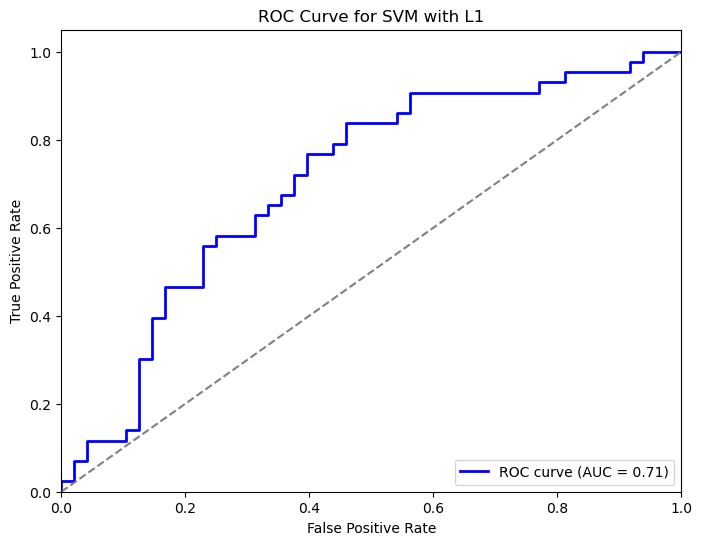

In [58]:
y_pred_proba_svm_l1 = calibrated_clf_l1.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_pred_proba_test, title='ROC Curve for SVM with L1')

### Ridge (L2)

In [76]:
# Grid search for SVM with L2 hyperparameter:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],     # Regularization parameter
    'penalty': ['l2'],                             # Penalty type (L2 regularization)
    'loss': ['squared_hinge', 'hinge'],            # Loss function
    'dual': [True, False],                         # Whether to solve the dual or primal problem
    'fit_intercept': [True, False],                # Whether to calculate the intercept
    'class_weight': [None, 'balanced']             # Class weights
}

# Initialize the L2 SVM classifier
clf_SVM_L2_grid = LinearSVC(max_iter=10000)  # No need to specify penalty for L2

# Perform grid search
grid_search = GridSearchCV(estimator=clf_SVM_L2_grid, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

C:\Users\pamin\miniconda3\envs\FODS\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
140 fits failed out of a total of 560.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\pamin\miniconda3\envs\FODS\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\pamin\miniconda3\envs\FODS\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\pamin\miniconda3\envs\FODS\Lib\site-packages\sklearn\svm\_classes.

Best Parameters: {'C': 0.01, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'loss': 'squared_hinge', 'penalty': 'l2'}
Best Score: 0.6039193302891933


In [59]:
# Train SVM model with selscted features from L2 and hyperparameter
clf_SVM_l2 = LinearSVC(penalty='l2', dual=True, C = 0.01, fit_intercept = True, loss = 'squared_hinge', class_weight = None)
clf_SVM_l2.fit(X_train, y_train)

calibrated_clf_l2 = CalibratedClassifierCV(clf_SVM_l2, method='sigmoid')
calibrated_clf_l2.fit(X_train, y_train)

# Evaluate performance on the test set
y_pred_proba_test = calibrated_clf_l2.predict_proba(X_test)[:, 1]
y_pred_test = calibrated_clf_l2.predict(X_test)
tp_test, fp_test, tn_test, fn_test, accuracy_test, precision_test, recall_test, specificity_test, f1_test, roc_auc_test = eval_Performance(y_test, X_test, calibrated_clf_l2, clf_name='SVM L2 (test)')

# Evaluate performance on the training set
y_pred_proba_train = calibrated_clf_l2.predict_proba(X_train)[:, 1]
y_pred_train = calibrated_clf_l2.predict(X_train)
tp_train, fp_train, tn_train, fn_train, accuracy_train, precision_train, recall_train, specificity_train, f1_train, roc_auc_train = eval_Performance(y_train, X_train, calibrated_clf_l2, clf_name='SVM L2 (train)')

# Store the evaluation metrics in the DataFrame
df_performance_SVM.loc['SVM L2 (test)', :] = [tp_test, fp_test, tn_test, fn_test, accuracy_test, precision_test, recall_test, specificity_test, f1_test, roc_auc_test]
df_performance_SVM.loc['SVM L2 (train)', :] = [tp_train, fp_train, tn_train, fn_train, accuracy_train, precision_train, recall_train, specificity_train, f1_train, roc_auc_train]

print(df_performance_SVM)

                   tp  fp   tn   fn  accuracy precision    recall specificity        f1   roc_auc
SVM (test)         18  15   33   25   0.56044   0.55721    0.6875    0.553052  0.548163   0.51187
SVM (train)        81  55  162   63   0.67313  0.657794  0.746544    0.654522  0.655802  0.616615
SVM UVFS (test)    10  16   32   33  0.461538  0.438462  0.666667    0.449612  0.428113  0.539486
SVM UVFS (train)  140   0  217    4   0.98892   0.99095       1.0    0.986111  0.988392  0.999968
SVM L1 (test)      16   7   41   27  0.626374  0.649297  0.854167     0.61313  0.595873  0.705426
SVM L1 (train)     60  16  201   84  0.722992  0.747368  0.926267    0.671467  0.673126  0.748688
SVM L2 (test)       3   3   45   40  0.527473  0.514706    0.9375    0.503634   0.39957  0.611919
SVM L2 (train)     24   0  217  120   0.66759  0.821958       1.0    0.583333  0.534554  0.998432


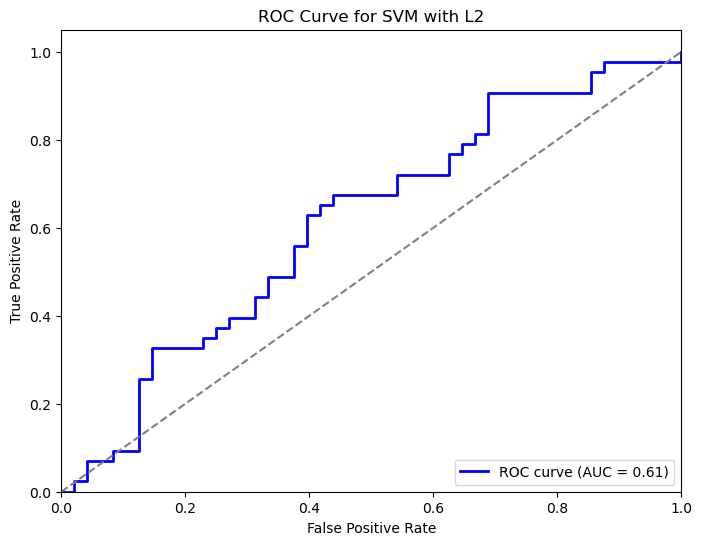

In [60]:
y_pred_proba_svm_l2 = calibrated_clf_l2.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_pred_proba_test, title='ROC Curve for SVM with L2')

### Balanced subset

In [41]:
# Grid search for SVM with balaced subset hyperparameter:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],       # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Kernel function
    'gamma': ['scale', 'auto'],                      # Kernel coefficient
    'degree': [2, 3, 4, 5],                          # Degree of polynomial kernel (if applicable)
    'coef0': [0.0, 0.1, 0.5, 1.0]                    # Coefficient for polynomial and sigmoid kernels (if applicable)
}

# Initialize the SVM classifier
clf_SVM_sub = svm.SVC(probability=True)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=clf_SVM_sub, param_grid=param_grid, cv=5, scoring='accuracy')

# Perform grid search
grid_search.fit(X_train_sub, y_train_sub)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found:", best_params)
print("Best score:", grid_search.best_score_)

Best parameters found: {'C': 10, 'coef0': 0.5, 'degree': 4, 'gamma': 'auto', 'kernel': 'poly'}
Best score: 0.76


In [61]:
# Fit model
clf_SVM_sub = svm.SVC(probability=True, kernel='poly', C = 10, gamma = 'auto', degree = 4, coef0 = 0.5)
clf_SVM_sub.fit(X_train_sub, y_train_sub)

# Evaluate performance
df_performance_SVM.loc['SVM balanced subset (test)', :] = eval_Performance(y_test_sub, X_test_sub, clf_SVM_sub, clf_name='SVM balanced subset (test)')
df_performance_SVM.loc['SVM balanced subset (train)', :] = eval_Performance(y_train_sub, X_train_sub, clf_SVM_sub, clf_name='SVM balanced subset (train)')

# Display performance
print(df_performance_SVM)

                              tp  fp   tn   fn  accuracy precision    recall specificity        f1   roc_auc
SVM (test)                    18  15   33   25   0.56044   0.55721    0.6875    0.553052  0.548163   0.51187
SVM (train)                   81  55  162   63   0.67313  0.657794  0.746544    0.654522  0.655802  0.616615
SVM UVFS (test)               10  16   32   33  0.461538  0.438462  0.666667    0.449612  0.428113  0.539486
SVM UVFS (train)             140   0  217    4   0.98892   0.99095       1.0    0.986111  0.988392  0.999968
SVM L1 (test)                 16   7   41   27  0.626374  0.649297  0.854167     0.61313  0.595873  0.705426
SVM L1 (train)                60  16  201   84  0.722992  0.747368  0.926267    0.671467  0.673126  0.748688
SVM L2 (test)                  3   3   45   40  0.527473  0.514706    0.9375    0.503634   0.39957  0.611919
SVM L2 (train)                24   0  217  120   0.66759  0.821958       1.0    0.583333  0.534554  0.998432
SVM balanced subset

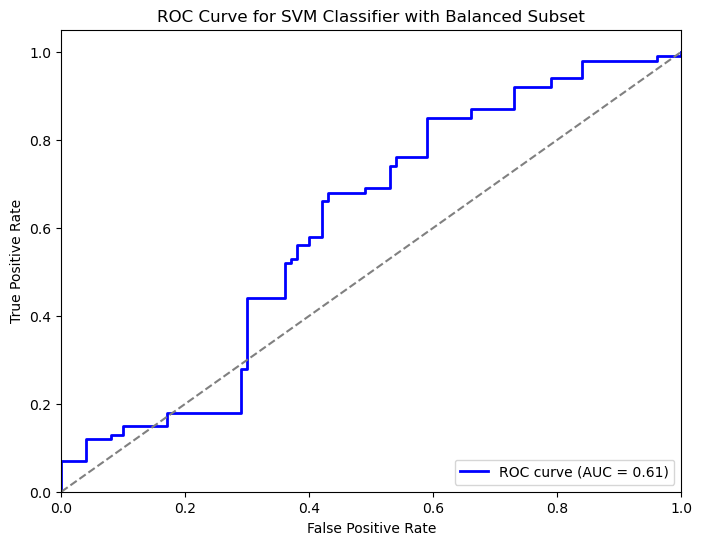

In [62]:
y_pred_proba_sub = clf_SVM_sub.predict_proba(X_test_sub)[:, 1]
plot_roc_curve(y_test_sub, y_pred_proba_sub, title='ROC Curve for SVM Classifier with Balanced Subset')

### Results SVM

In [63]:
print(df_performance_SVM)

                              tp  fp   tn   fn  accuracy precision    recall specificity        f1   roc_auc
SVM (test)                    18  15   33   25   0.56044   0.55721    0.6875    0.553052  0.548163   0.51187
SVM (train)                   81  55  162   63   0.67313  0.657794  0.746544    0.654522  0.655802  0.616615
SVM UVFS (test)               10  16   32   33  0.461538  0.438462  0.666667    0.449612  0.428113  0.539486
SVM UVFS (train)             140   0  217    4   0.98892   0.99095       1.0    0.986111  0.988392  0.999968
SVM L1 (test)                 16   7   41   27  0.626374  0.649297  0.854167     0.61313  0.595873  0.705426
SVM L1 (train)                60  16  201   84  0.722992  0.747368  0.926267    0.671467  0.673126  0.748688
SVM L2 (test)                  3   3   45   40  0.527473  0.514706    0.9375    0.503634   0.39957  0.611919
SVM L2 (train)                24   0  217  120   0.66759  0.821958       1.0    0.583333  0.534554  0.998432
SVM balanced subset

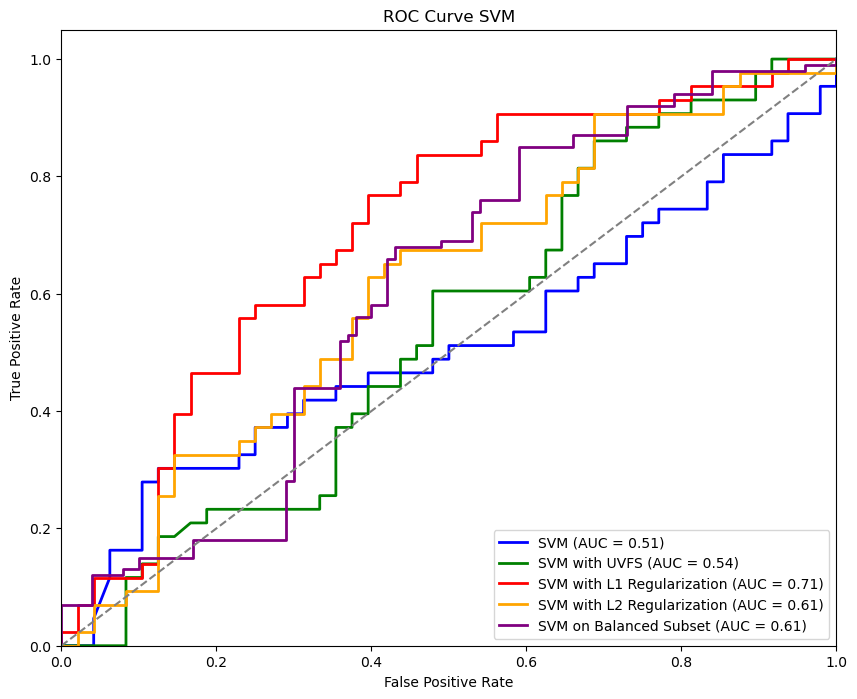

In [64]:
plt.figure(figsize=(10, 8))

# Plot ROC curve for each SVM classifier
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_proba_svm)
fpr_svm_uvfs, tpr_svm_uvfs, _ = roc_curve(y_test, y_pred_proba_svm_uvfs)
fpr_svm_l1, tpr_svm_l1, _ = roc_curve(y_test, y_pred_proba_svm_l1)
fpr_svm_sub, tpr_svm_sub, _ = roc_curve(y_test_sub, y_pred_proba_sub)
fpr_svm_l2, tpr_svm_l2, _ = roc_curve(y_test, y_pred_proba_svm_l2)

plt.plot(fpr_svm, tpr_svm, color='blue', lw=2, label='SVM (AUC = %0.2f)' % auc(fpr_svm, tpr_svm))
plt.plot(fpr_svm_uvfs, tpr_svm_uvfs, color='green', lw=2, label='SVM with UVFS (AUC = %0.2f)' % auc(fpr_svm_uvfs, tpr_svm_uvfs))
plt.plot(fpr_svm_l1, tpr_svm_l1, color='red', lw=2, label='SVM with L1 Regularization (AUC = %0.2f)' % auc(fpr_svm_l1, tpr_svm_l1))
plt.plot(fpr_svm_l2, tpr_svm_l2, color='orange', lw=2, label='SVM with L2 Regularization (AUC = %0.2f)' % auc(fpr_svm_l2, tpr_svm_l2))
plt.plot(fpr_svm_sub, tpr_svm_sub, color='purple', lw=2, label='SVM on Balanced Subset (AUC = %0.2f)' % auc(fpr_svm_sub, tpr_svm_sub))

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve SVM')
plt.legend(loc='lower right')
plt.show()

## Random Forest

### Basic model

In [42]:
# Grid search for RF hyperparameter:
param_grid = {
    'n_estimators': [50, 100, 200, 300],        # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],             # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],             # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]                # Minimum number of samples required at each leaf node
}

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Create GridSearchCV object
grid_search_rf = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Perform grid search
grid_search_rf.fit(X_train, y_train)

# Get the best parameters
best_params_rf = grid_search_rf.best_params_
print("Best parameters found:", best_params_rf)
print("Best score:", grid_search.best_score_)

Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best score: 0.76


In [65]:
# Train Random Forest model with the best parameters
best_rf_clf = RandomForestClassifier(max_depth = None, min_samples_leaf = 4, min_samples_split = 10, n_estimators = 200, random_state=42)
best_rf_clf.fit(X_train, y_train)

# Evaluate the performance of the model
df_performance_RF = pd.DataFrame(columns = ['tp','fp','tn','fn','accuracy', 'precision', 'recall', 'specificity', 'f1', 'roc_auc'] )
df_performance_RF.loc['RF (test)', :] = eval_Performance(y_test, X_test, best_rf_clf, clf_name='RF (test)')
df_performance_RF.loc['RF (train)', :] = eval_Performance(y_train, X_train, best_rf_clf, clf_name='RF (train)')

print(df_performance_RF)

             tp fp   tn  fn  accuracy precision  recall specificity        f1   roc_auc
RF (test)    11  9   39  32  0.549451  0.549648  0.8125    0.534157  0.502334  0.608043
RF (train)  141  0  217   3   0.99169  0.993182     1.0    0.989583  0.991304       1.0


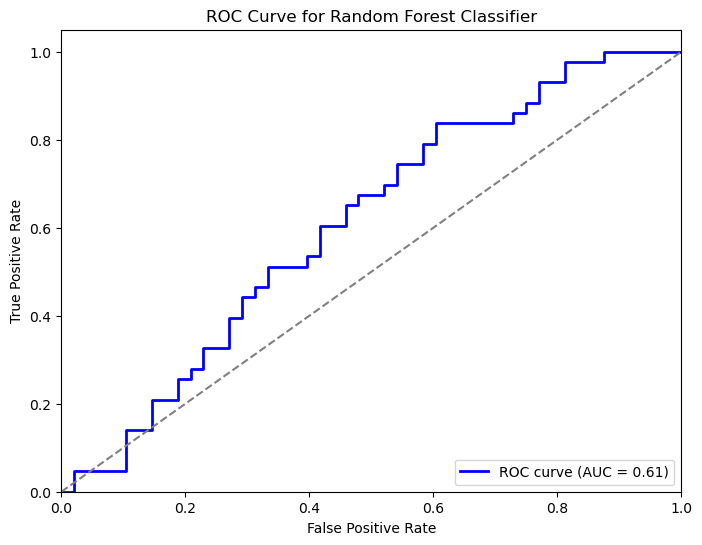

In [66]:
y_pred_proba_rf = best_rf_clf.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_pred_proba_rf, title='ROC Curve for Random Forest Classifier')

In [43]:
# Grid search for RF hyperparameter:
param_grid = {
    'n_estimators': [50, 100, 200, 300],        # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],             # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],             # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]                # Minimum number of samples required at each leaf node
}

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Create GridSearchCV object
grid_search_rf = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Perform grid search
grid_search_rf.fit(X_train_sub, y_train_sub)

# Get the best parameters
best_params_rf = grid_search_rf.best_params_
print("Best parameters found:", best_params_rf)
print("Best score:", grid_search.best_score_)

Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best score: 0.76


In [67]:
# Train Random Forest model with the best parameters
best_rf_clf = RandomForestClassifier(max_depth = None, min_samples_leaf = 1, min_samples_split = 5, n_estimators = 100, random_state=42)
best_rf_clf.fit(X_train_sub, y_train_sub)

# Evaluate the performance of the model
df_performance_RF.loc['RF Balanced Subset (test)', :] = eval_Performance(y_test_sub, X_test_sub, best_rf_clf, clf_name='RF Balanced Subset (test)')
df_performance_RF.loc['RF Balanced Subset (train)', :] = eval_Performance(y_train_sub, X_train_sub, best_rf_clf, clf_name='RF Balanced Subset (train)')

print(df_performance_RF)

                             tp  fp   tn  fn  accuracy precision  recall specificity        f1   roc_auc
RF (test)                    11   9   39  32  0.549451  0.549648  0.8125    0.534157  0.502334  0.608043
RF (train)                  141   0  217   3   0.99169  0.993182     1.0    0.989583  0.991304       1.0
RF Balanced Subset (test)    55  49   51  45      0.53  0.530048    0.51        0.53  0.529812    0.5249
RF Balanced Subset (train)  100   0  100   0       1.0       1.0     1.0         1.0       1.0       1.0


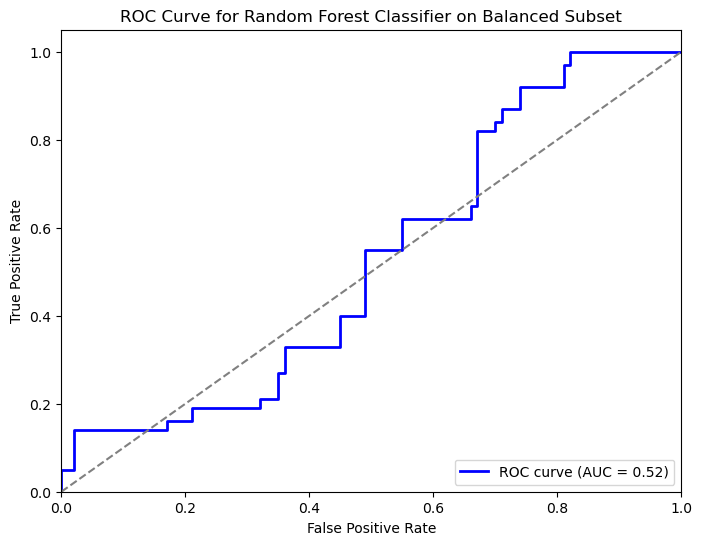

In [68]:
y_pred_proba_rf_sub = best_rf_clf.predict_proba(X_test_sub)[:, 1]
plot_roc_curve(y_test_sub, y_pred_proba_rf_sub, title='ROC Curve for Random Forest Classifier on Balanced Subset')

### Results Random Forest

In [69]:
print(df_performance_RF)

                             tp  fp   tn  fn  accuracy precision  recall specificity        f1   roc_auc
RF (test)                    11   9   39  32  0.549451  0.549648  0.8125    0.534157  0.502334  0.608043
RF (train)                  141   0  217   3   0.99169  0.993182     1.0    0.989583  0.991304       1.0
RF Balanced Subset (test)    55  49   51  45      0.53  0.530048    0.51        0.53  0.529812    0.5249
RF Balanced Subset (train)  100   0  100   0       1.0       1.0     1.0         1.0       1.0       1.0


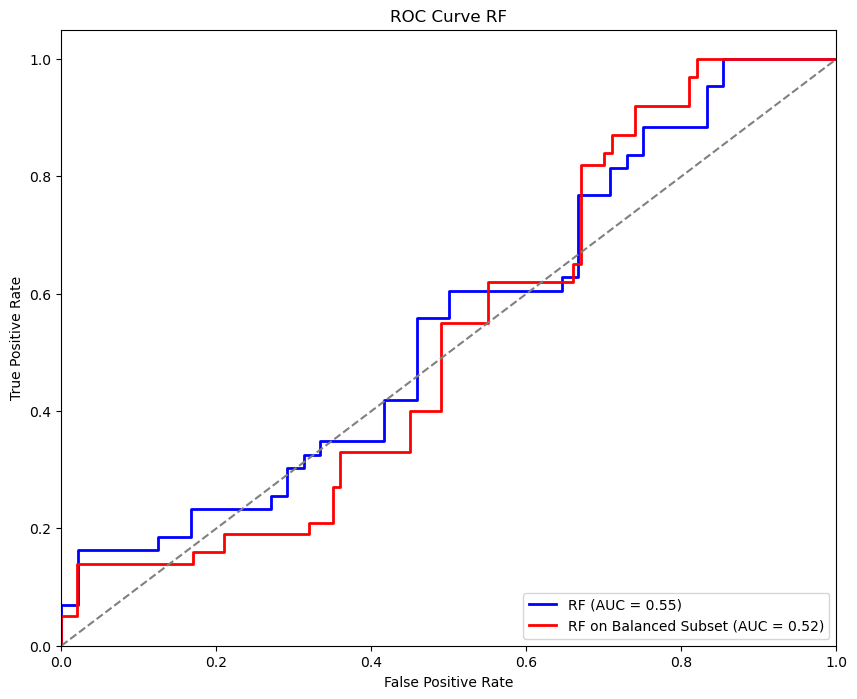

In [70]:
y_pred_proba_rf = best_rf_clf.predict_proba(X_test)[:, 1]
y_pred_proba_rf_sub = best_rf_clf.predict_proba(X_test_sub)[:, 1]

# Compute ROC curve for both Random Forest classifiers
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
fpr_rf_sub, tpr_rf_sub, _ = roc_curve(y_test_sub, y_pred_proba_rf_sub)

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label='RF (AUC = %0.2f)' % auc(fpr_rf, tpr_rf))
plt.plot(fpr_rf_sub, tpr_rf_sub, color='red', lw=2, label='RF on Balanced Subset (AUC = %0.2f)' % auc(fpr_rf_sub, tpr_rf_sub))

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve RF')
plt.legend(loc='lower right')
plt.show()

## Gradient Boosting Machines (GBM) 

### Basic model

In [44]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7]
}

# Initialize the GBM classifier
gbm_classifier = GradientBoostingClassifier(random_state=42)

# Create GridSearchCV object
grid_search_gbm = GridSearchCV(estimator=gbm_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the training data
grid_search_gbm.fit(X_train, y_train)

# Get the best parameters
best_params_gbm = grid_search_gbm.best_params_
print("Best parameters found:", best_params_gbm)
print("Best score:", grid_search.best_score_)

Best parameters found: {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 50}
Best score: 0.76


In [71]:
# Initialize the GBM classifier with found hyperparameters
gbm_classifier = GradientBoostingClassifier(random_state=42, learning_rate = 0.5, max_depth = 3, n_estimators = 50)

# Fit the classifier to the training data
gbm_classifier.fit(X_train, y_train)

# Create an empty DataFrame to store performance metrics
df_performance_GBM = pd.DataFrame(columns=['tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'specificity', 'f1', 'roc_auc'])

# Evaluate the GBM model on the test set and train set
df_performance_GBM.loc['GBM (test)', :] = eval_Performance(y_test, X_test, gbm_classifier, clf_name='GBM (test)')
df_performance_GBM.loc['GBM (train)', :] = eval_Performance(y_train, X_train, gbm_classifier, clf_name='GBM (train)')

# Print the performance metrics DataFrame
print(df_performance_GBM)

              tp  fp   tn  fn  accuracy precision    recall specificity        f1   roc_auc
GBM (test)    18  11   37  25  0.604396  0.608732  0.770833    0.594719  0.586364  0.584787
GBM (train)  144   0  217   0       1.0       1.0       1.0         1.0       1.0       1.0


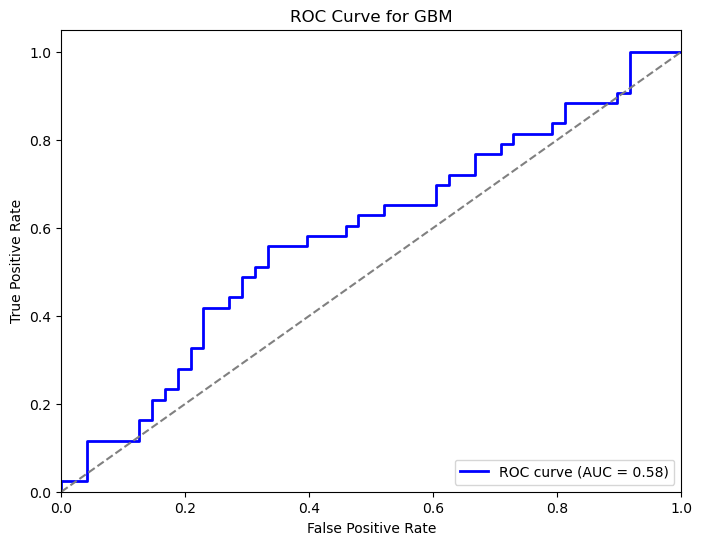

In [72]:
y_pred_proba_gbm = gbm_classifier.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_pred_proba_gbm, title='ROC Curve for GBM')

### Balanced Subset

In [45]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7]
}

# Initialize the GBM classifier
gbm_classifier = GradientBoostingClassifier(random_state=42)

# Create GridSearchCV object
grid_search_gbm = GridSearchCV(estimator=gbm_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the training data
grid_search_gbm.fit(X_train_sub, y_train_sub)

# Get the best parameters
best_params_gbm = grid_search_gbm.best_params_
print("Best parameters found:", best_params_gbm)
print("Best score:", grid_search.best_score_)

Best parameters found: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
Best score: 0.76


In [73]:
# Initialize the GBM classifier with found hyperparameters
gbm_classifier = GradientBoostingClassifier(random_state=42, learning_rate = 0.1, max_depth = 7, n_estimators = 100)

# Fit the classifier to the training data
gbm_classifier.fit(X_train_sub, y_train_sub)

# Create an empty DataFrame to store performance metrics
# Evaluate the GBM model on the test set and train set
df_performance_GBM.loc['GBM Balanced Subset (test)', :] = eval_Performance(y_test_sub, X_test_sub, gbm_classifier, clf_name='GBM Balanced Subset (test)')
df_performance_GBM.loc['GBM Balanced Subset (train)', :] = eval_Performance(y_train_sub, X_train_sub, gbm_classifier, clf_name='GBM Balanced Subset (train)')

# Print the performance metrics DataFrame
print(df_performance_GBM)

                              tp  fp   tn  fn  accuracy precision    recall specificity        f1   roc_auc
GBM (test)                    18  11   37  25  0.604396  0.608732  0.770833    0.594719  0.586364  0.584787
GBM (train)                  144   0  217   0       1.0       1.0       1.0         1.0       1.0       1.0
GBM Balanced Subset (test)    45  47   53  55      0.49  0.489936      0.53        0.49  0.489183    0.4889
GBM Balanced Subset (train)  100   0  100   0       1.0       1.0       1.0         1.0       1.0       1.0


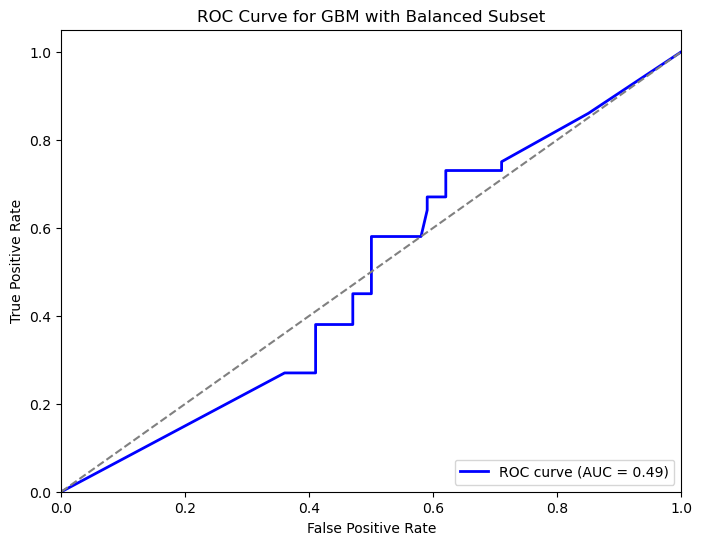

In [74]:
y_pred_proba_gbm_sub = gbm_classifier.predict_proba(X_test_sub)[:, 1]
plot_roc_curve(y_test_sub, y_pred_proba_gbm_sub, title='ROC Curve for GBM with Balanced Subset')

### Results GBM

In [75]:
print(df_performance_GBM)

                              tp  fp   tn  fn  accuracy precision    recall specificity        f1   roc_auc
GBM (test)                    18  11   37  25  0.604396  0.608732  0.770833    0.594719  0.586364  0.584787
GBM (train)                  144   0  217   0       1.0       1.0       1.0         1.0       1.0       1.0
GBM Balanced Subset (test)    45  47   53  55      0.49  0.489936      0.53        0.49  0.489183    0.4889
GBM Balanced Subset (train)  100   0  100   0       1.0       1.0       1.0         1.0       1.0       1.0


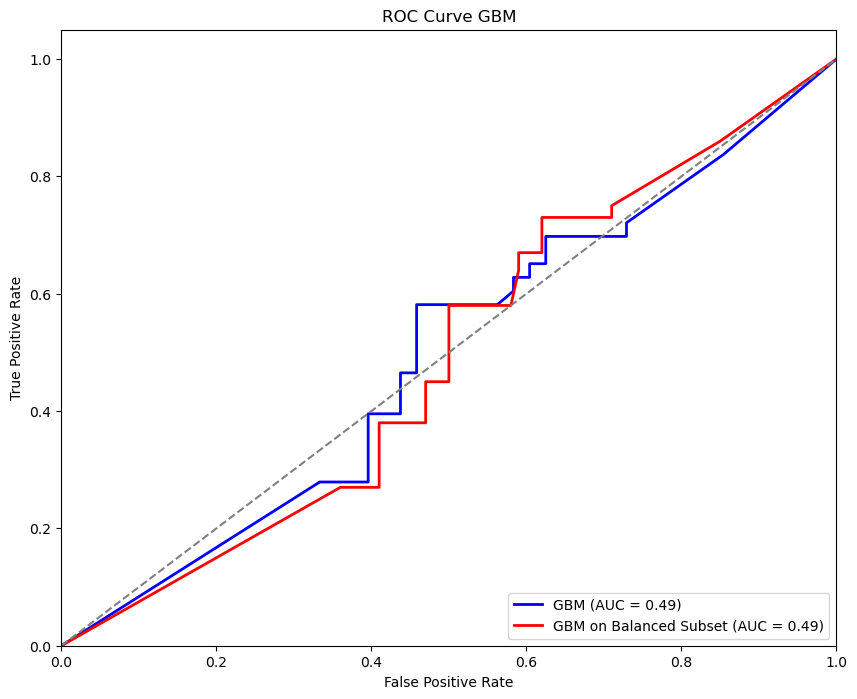

In [76]:
y_pred_proba_gbm = gbm_classifier.predict_proba(X_test)[:, 1]
y_pred_proba_gbm_sub = gbm_classifier.predict_proba(X_test_sub)[:, 1]

# Compute ROC curve for both GBM classifiers
fpr_gbm, tpr_gbm, _ = roc_curve(y_test, y_pred_proba_gbm)
fpr_gbm_sub, tpr_gbm_sub, _ = roc_curve(y_test_sub, y_pred_proba_gbm_sub)

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_gbm, tpr_gbm, color='blue', lw=2, label='GBM (AUC = %0.2f)' % auc(fpr_gbm, tpr_gbm))
plt.plot(fpr_gbm_sub, tpr_gbm_sub, color='red', lw=2, label='GBM on Balanced Subset (AUC = %0.2f)' % auc(fpr_gbm_sub, tpr_gbm_sub))

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve GBM')
plt.legend(loc='lower right')
plt.show()

# Fitting best model per gender

In [77]:
# Separate the dataset into genders
female_df = data_ML.loc[data_ML['Gender'] == 0]
male_df = data_ML.loc[data_ML['Gender'] == 1]

# female
data_ML.reset_index(drop=True, inplace=True)
female_indices = female_df.index
y_f = female_df.loc[female_indices, 'Survival_from_surgery_days']

# male
data.reset_index(drop=True, inplace=True)
male_indices = male_df.index
y_m = male_df.loc[male_indices, 'Survival_from_surgery_days']

In [78]:
female_df.drop(columns='Gender')
male_df.drop(columns='Gender')

Age_at_scan_years  Survival_from_surgery_days  IDH1  GTR_over90percent  FLAIR_ED_Intensity_Energy  FLAIR_ED_Intensity_InterQuartileRange  FLAIR_ED_Intensity_Kurtosis  FLAIR_ED_Intensity_Maximum  FLAIR_ED_Intensity_Mean  FLAIR_ED_Intensity_Median  FLAIR_ED_Intensity_MedianAbsoluteDeviation  FLAIR_ED_Intensity_Minimum  FLAIR_ED_Intensity_Mode  FLAIR_ED_Intensity_NinetiethPercentile  FLAIR_ED_Intensity_Range  FLAIR_ED_Intensity_RootMeanSquare  FLAIR_ED_Intensity_Skewness  FLAIR_ED_Intensity_StandardDeviation  FLAIR_ED_Intensity_Sum  FLAIR_ED_Intensity_TenthPercentile  FLAIR_ED_Intensity_Variance  FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-0_Frequency  FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-10_Frequency  FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-11_Frequency  FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-12_Frequency  FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-13_Frequency  FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-14_Frequency  FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-15_Frequency  FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-1_Frequency  FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-2_Frequency  FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-3_Frequency  FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-4_Frequency  FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-5_Frequency  FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-6_Frequency  FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-7_Frequency  FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-8_Frequency  FLAIR_ED_Histogram_Bins-16_Bins-16_Bin-9_Frequency  FLAIR_ED_Histogram_Bins-16_Bins-16_Energy  FLAIR_ED_Histogram_Bins-16_Bins-16_Entropy  FLAIR_ED_Histogram_Bins-16_Bins-16_FifthPercentile  FLAIR_ED_Histogram_Bins-16_Bins-16_FifthPercentileMean  FLAIR_ED_Histogram_Bins-16_Bins-16_InterQuartileRange  FLAIR_ED_Histogram_Bins-16_Bins-16_Kurtosis  FLAIR_ED_Histogram_Bins-16_Bins-16_Mean  FLAIR_ED_Histogram_Bins-16_Bins-16_Median  FLAIR_ED_Histogram_Bins-16_Bins-16_MedianAbsoluteDeviation  FLAIR_ED_Histogram_Bins-16_Bins-16_Mode  FLAIR_ED_Histogram_Bins-16_Bins-16_NinetiethPercentile  FLAIR_ED_Histogram_Bins-16_Bins-16_NinetyFifthPercentile  FLAIR_ED_Histogram_Bins-16_Bins-16_NinetyFifthPercentileMean  FLAIR_ED_Histogram_Bins-16_Bins-16_RobustMeanAbsoluteDeviation1090  FLAIR_ED_Histogram_Bins-16_Bins-16_RootMeanSquare  FLAIR_ED_Histogram_Bins-16_Bins-16_SeventyFifthPercentile  FLAIR_ED_Histogram_Bins-16_Bins-16_Skewness  FLAIR_ED_Histogram_Bins-16_Bins-16_StandardDeviation  FLAIR_ED_Histogram_Bins-16_Bins-16_Sum  FLAIR_ED_Histogram_Bins-16_Bins-16_TenthPercentile  FLAIR_ED_Histogram_Bins-16_Bins-16_TwentyFifthPercentile  FLAIR_ED_Histogram_Bins-16_Bins-16_Variance  FLAIR_ED_Volumetric_Pixels  FLAIR_ED_Volumetric_Volume  FLAIR_ED_Morphologic_EllipseDiameter_Axis-0  FLAIR_ED_Morphologic_EllipseDiameter_Axis-1  FLAIR_ED_Morphologic_EllipseDiameter_Axis-2  FLAIR_ED_Morphologic_Elongation  FLAIR_ED_Morphologic_EquivalentSphericalPerimeter  FLAIR_ED_Morphologic_EquivalentSphericalRadius  FLAIR_ED_Morphologic_Flatness  FLAIR_ED_Morphologic_LargestComponentSize  FLAIR_ED_Morphologic_NumberOfPixels  FLAIR_ED_Morphologic_Perimeter  FLAIR_ED_Morphologic_PerimeterOnBorder  FLAIR_ED_Morphologic_PhysicalSize  FLAIR_ED_Morphologic_PixelsOnBorder  FLAIR_ED_GLCM_Bins-16_Radius-1_AutoCorrelation  FLAIR_ED_GLCM_Bins-16_Radius-1_ClusterProminence  FLAIR_ED_GLCM_Bins-16_Radius-1_ClusterShade  FLAIR_ED_GLCM_Bins-16_Radius-1_Contrast  FLAIR_ED_GLCM_Bins-16_Radius-1_Correlation  FLAIR_ED_GLCM_Bins-16_Radius-1_Entropy  FLAIR_ED_GLRLM_Bins-16_Radius-1_GreyLevelNonuniformity  FLAIR_ED_GLRLM_Bins-16_Radius-1_HighGreyLevelRunEmphasis  FLAIR_ED_GLRLM_Bins-16_Radius-1_LongRunHighGreyLevelEmphasis  FLAIR_ED_GLRLM_Bins-16_Radius-1_RunLengthNonuniformity  FLAIR_ED_GLRLM_Bins-16_Radius-1_ShortRunHighGreyLevelEmphasis  FLAIR_ED_GLSZM_Bins-16_Radius-1_GreyLevelMean  FLAIR_ED_GLSZM_Bins-16_Radius-1_GreyLevelNonUniformity  FLAIR_ED_GLSZM_Bins-16_Radius-1_GreyLevelVariance  FLAIR_ED_GLSZM_Bins-16_Radius-1_HighGreyLevelEmphasis  FLAIR_ED_GLSZM_Bins-16_Radius-1_LargeZoneEmphasis  FLAIR_ED_GLSZM_Bins-16_Radius-1_

In [79]:
# create female training-and testset
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    female_df,
    y_f,
    test_size=0.2,
    random_state=1
)
print('Size Female Trainingsset: ', X_train_f.shape[0], ', Size Female Testset: ', X_test_f.shape[0])

# create male training-and testset
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    male_df,
    y_m,
    test_size=0.2,
    random_state=1
)
print('Size Male Trainingsset: ', X_train_m.shape[0], ', Size Male Testset: ', X_test_m.shape[0])

Size Female Trainingsset:  141 , Size Female Testset:  36
Size Male Trainingsset:  220 , Size Male Testset:  55


In [80]:
# fit best model on this training-/testset 
# female
clf_LR_best_f = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=1, fit_intercept = True, intercept_scaling = 1, tol = 0.01)
clf_LR_best_f.fit(X_train_f, y_train_f)

df_performance_gender = pd.DataFrame(columns = ['tp','fp','tn','fn','accuracy', 'precision', 'recall', 'specificity', 'f1', 'roc_auc'] )
df_performance_gender.loc['LR_f (test)',:] = eval_Performance(y_test_f, X_test_f, clf_LR_best_f, clf_name = 'LR_f')
df_performance_gender.loc['LR_f (train)',:] = eval_Performance(y_train_f, X_train_f, clf_LR_best_f, clf_name = 'LR_f (train)')

# male
clf_LR_best_m = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=1, fit_intercept = True, intercept_scaling = 1, tol = 0.01)
clf_LR_best_m.fit(X_train_m, y_train_m)

df_performance_gender.loc['LR_m (test)',:] = eval_Performance(y_test_m, X_test_m, clf_LR_best_m, clf_name = 'LR_m')
df_performance_gender.loc['LR_m (train)',:] = eval_Performance(y_train_m, X_train_m, clf_LR_best_m, clf_name = 'LR_m (train)')

print(df_performance_gender)

              tp  fp   tn  fn  accuracy precision    recall specificity        f1   roc_auc
LR_f (test)    6  10   14   6  0.555556    0.5375  0.583333    0.541667  0.532468  0.486111
LR_f (train)  59   0   82   0       1.0       1.0       1.0         1.0       1.0       1.0
LR_m (test)    8  10   19  18  0.490909  0.478979  0.655172    0.481432  0.469697  0.486737
LR_m (train)  90   0  130   0       1.0       1.0       1.0         1.0       1.0       1.0


# Fitting best model per age

In [81]:
# create the different datasets
age_young_df = data_ML[(data_ML['Age_at_scan_years'] < 60)]
age_old_df =  data_ML[(data_ML['Age_at_scan_years'] > 60)]

# the corresponding label
young_indices = age_young_df.index
y_young = data_ML.loc[young_indices, 'Survival_from_surgery_days']

old_indices = age_old_df.index
y_old = data_ML.loc[old_indices, 'Survival_from_surgery_days']

In [82]:
# create training-and testset for younger patients (<60)
X_train_young, X_test_young, y_train_young, y_test_young = train_test_split(
    age_young_df,
    y_young,
    test_size=0.2,
    random_state=1
)
print('Size Trainingsset (younger patients): ', X_train_young.shape[0], ', Size Testset (younger patients): ', X_test_young.shape[0])

# create training-and testset for old patients (>70)
X_train_old, X_test_old, y_train_old, y_test_old = train_test_split(
    age_old_df,
    y_old,
    test_size=0.2,
    random_state=1
)
print('Size Trainingsset (elderly patients): ', X_train_old.shape[0], ', Size Testset (elderly patients): ', X_test_old.shape[0])

Size Trainingsset (younger patients):  131 , Size Testset (younger patients):  33
Size Trainingsset (elderly patients):  230 , Size Testset (elderly patients):  58


In [83]:
# fit best model on this training-/testset
# younger aged patients
clf_LR_best_y = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=1, fit_intercept = True, intercept_scaling = 1, tol = 0.01)
clf_LR_best_y.fit(X_train_young, y_train_young)

df_performance_age = pd.DataFrame(columns = ['tp','fp','tn','fn','accuracy', 'precision', 'recall', 'specificity', 'f1', 'roc_auc'] )
df_performance_age.loc['LR young (test)',:] = eval_Performance(y_test_young, X_test_young, clf_LR_best_y, clf_name = 'LR young')
df_performance_age.loc['LR young (train)',:] = eval_Performance(y_train_young, X_train_young, clf_LR_best_y, clf_name = 'LR young (train)')

# old patients
clf_LR_best_o = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=1, fit_intercept = True, intercept_scaling = 1, tol = 0.01)
clf_LR_best_o.fit(X_train_old, y_train_old)

df_performance_age.loc['LR old (test)',:] = eval_Performance(y_test_old, X_test_old, clf_LR_best_o, clf_name = 'LR old')
df_performance_age.loc['LR old (train)',:] = eval_Performance(y_train_old, X_train_old, clf_LR_best_o, clf_name = 'LR old (train)')

print(df_performance_age)

                  tp  fp   tn  fn  accuracy precision    recall specificity        f1   roc_auc
LR young (test)    5  14    5   9   0.30303   0.31015  0.263158     0.31015   0.30303  0.323308
LR young (train)  81   0   50   0       1.0       1.0       1.0         1.0       1.0       1.0
LR old (test)      6   8   27  17  0.568966  0.521104  0.771429    0.516149  0.503934  0.627329
LR old (train)    69   0  161   0       1.0       1.0       1.0         1.0       1.0       1.0
